In [1]:
#!pip install atomicwrites h5py lz4 ujson msgpack luxai_s2 wandb scikit-image

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import torch
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
import torch.optim as optim
import numpy as np
import pandas as pd

from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
from types import SimpleNamespace
import time
import gc

np_dtype = np.float32
torch_dtype = torch.float32
amp_dtype = torch.float32  # or torch.bfloat16
EPS=1e-5

torch.backends.cudnn.benchmark = True

In [3]:
assert torch.cuda.is_available()

In [4]:
use_cuda = torch.cuda.is_available()
device_name = "cuda:0" if use_cuda else "cpu"
device = torch.device(device_name)
torch.autograd.set_detect_anomaly(True)
print(device)

cuda:0


In [5]:
import wandb
USE_WANDB = True
storage_dir = "./models/"
proj_name = "la2022v3_ILv12"
mdl_prefix = "il12v1_a9_s3"
net_suffix = f"{mdl_prefix}_run_{int(time.time())}"

config = SimpleNamespace(lr_bid=0.003, lr_placement=0.003, lr_game=0.003,
                         lr_gamma_bid = 0.95, lr_gamma_placement = 0.95, lr_gamma_game = 0.95,
                         weighting_rate=0.05,
                         batch_size_bid=64,batch_size_placement=64,batch_size_game=64,
                         epochs_bid=100, epochs_placement=100, epochs_game=100,
                         DATASET_LIMIT=1000000, device=device_name, train_game=True, train_placement=False, train_bid=False,
                         game_load_from=None,
                        )

In [6]:
import torch
import random
import numpy as np

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    if seed_value is not None:
        os.environ['PYTHONHASHSEED'] = str(seed_value)

    if seed_value is not None:
        torch.manual_seed(seed_value)
    else:
        torch.seed()
        
seed_everything(42)

In [7]:
from collections import defaultdict
import msgpack
import lz4.frame
import ujson
import sys
import copy
import time
from atomicwrites import atomic_write

In [8]:
from replay2 import load_replay

SUBMISSION_IDS=[31305324,31305378,31305398,31311397,31313810] # flg

In [9]:
import h5py
import pandas as pd

# hf1 = h5py.File('dataset_lz4_2.h5', 'r')
hf2 = h5py.File('dataset_lz4_a9.h5', 'r')

In [10]:
def extract_step_h5(hf, ix):
    stc = {"board":{}}
    for k in hf:
        if k.startswith("board_"):
            stc["board"][k[6:]] = hf[k][ix]
        else:
            stc[k] = hf[k][ix]
    res = {'board': copy.deepcopy(stc['board'])}
    res.update(msgpack.unpackb(stc['comp']))
    return res

def extract_step_h5_lz4(hf, ix):
    stc = {"board":{}}
    for k in hf:
        if k.startswith("board_"):
            stc["board"][k[6:]] = hf[k][ix]
        else:
            stc[k] = hf[k][ix]
    res = {'board': copy.deepcopy(stc['board'])}
    res.update(msgpack.unpackb(lz4.frame.decompress(stc['comp_lz4'])))
    return res

def extract_step_h5_lz4_compressed(hf, ix):
    stc = {"board":{}}
    for k in hf:
        if k.startswith("board_"):
            stc["board"][k[6:]] = hf[k][ix]
        else:
            stc[k] = hf[k][ix]
    return stc

def decompress_step(stc):
    res = {'board': copy.deepcopy(stc['board'])}
    res.update(msgpack.unpackb(lz4.frame.decompress(stc['comp_lz4'])))
    return res

In [11]:
import numpy as np

from lux.config import EnvConfig
from lux.kit import obs_to_game_state
from lux.unit import Unit, move_deltas
import copy
import skimage.segmentation
from scipy.signal import convolve2d, fftconvolve

from lux.utils import direction_to


def to_tuple(pos):
    if isinstance(pos, tuple):
        return pos
    if isinstance(pos, list):
        return tuple(pos)
    return tuple(pos.tolist())


STAGE_BID = 0
STAGE_PLACEMENT = 1
STAGE_ACT = 2


def distance(p1, p2):
    pd = int(np.sum(np.abs(p1 - p2)))
    return pd

def total_cargo(u:Unit):
    return u.cargo.ice + u.cargo.ore + u.cargo.metal + u.cargo.water

def get_nearest(p, p_candidates):
    min_dist = 1000
    min_p = None
    for pn in p_candidates:
        pd = distance(p,pn)
        if pd < min_dist:
            min_dist = pd
            min_p = pn
    return min_p, min_dist

def get_nearest_fromlist(pl, p_candidates):
    min_dist = 1000
    min_p = None
    for p in pl:
        for pn in p_candidates:
            pd = distance(p,pn)
            if pd < min_dist:
                min_dist = pd
                min_p = pn
    return min_p, min_dist

def get_nearest_fromlist_avoid(pl, p_candidates, avoid_list):
    min_dist = 1000
    candidates = []
    for p in pl:
        for pn in p_candidates:
            pd = distance(p,pn)
            if pd < min_dist:
                min_dist = pd
                candidates = [pn]
            elif pd == min_dist:
                candidates += [pn]

    if not candidates:
        return None, min_dist

    candidates.sort(key=lambda p: get_nearest_fromlist(p, avoid_list)[1], reverse=True)
    return candidates[0], min_dist


def flood_fill(bounds, pos_list):
    visited = np.zeros_like(bounds)
    to_visit = copy.copy(pos_list)
    out = np.zeros_like(bounds)
    while to_visit:
        pn = to_visit.pop(0)
        if visited[pn[0], pn[1]]:
            continue

        visited[pn[0], pn[1]] = 1
        if bounds[pn[0], pn[1]]:
            continue

        out[pn[0], pn[1]] = 1
        for d in range(1, 5):
            pv = pn + move_deltas[d]
            if pv[0] < 0 or pv[1] < 0 or pv[0] >= visited.shape[0] or pv[1] >= visited.shape[1]:
                continue
            if visited[pv[0], pv[1]]:
                continue
            to_visit += [pv]
    return out


def fast_flood_fill(bounds, cpos):
    bout = (bounds > 0).copy().astype(int)
    for p in cpos:
        skimage.segmentation.flood_fill(bout, to_tuple(p), 2, connectivity=1, in_place=True)
    return bout == 2

def make_force_map(pos, relax=0.1):
    ax, ay = np.ogrid[0:48, 0:48] 
    dst_map = np.abs(ax-pos[0])+np.abs(ay-pos[1])
    return 1.0/(dst_map**2+relax)

def make_dist_map(pos, relax=0.1):
    ax, ay = np.ogrid[0:48, 0:48] 
    dst_map = np.abs(ax-pos[0])+np.abs(ay-pos[1])
    return dst_map

class WrappedGameState2:
    def get_adjacent_full(self, pos):
        res = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                pa = to_tuple(pos + np.array([i, j]))
                if self.is_valid_pos(pa):
                    res += [pa]
        return res

    def is_valid_pos(self, target_pos):
        if target_pos[0] < 0 or target_pos[1] < 0 or target_pos[0] >= self.map_shape[0] or target_pos[1] >= self.map_shape[1]:
            return False
        return True


    def unit_direction_to(self, u, pos2, avoid_pos_set):
        if to_tuple(u.pos) == to_tuple(pos2):
            return 0
        ndir = None
        ndist = (1000,1000)
        for d in range(1,5):
            npos = u.pos + move_deltas[d]
            mc = u.move_cost(self.gs, d)
            if mc is None:
                continue
            if to_tuple(npos) in avoid_pos_set:
                continue
            dist = (distance(npos, pos2), mc)
            if dist < ndist:
                ndir = d
                ndist = dist
        if ndir is not None:
            return ndir

        return direction_to(u.pos, pos2)

    def can_move_direction(self, u:Unit, d):
        mc = u.move_cost(self.gs, d)
        if mc is not None and u.power >= mc + u.unit_cfg.ACTION_QUEUE_POWER_COST:
            return True
        return False

    def make_goodness_mask(self, player_name, min_rubble):
        player_id = int(player_name[-1])
        opponent_id = 1 - player_id
        opponent_name = f"player_{opponent_id}"
        bounds_orig = (self.gs.board.rubble > min_rubble) | (self.ice_without_factories > 0) | (self.ore_without_factories > 0) | (self.factory_tiles[opponent_name])

        goodness = np.zeros(self.gs.board.rubble.shape, dtype=np.float32)
        for pos in np.argwhere(self.gs.board.valid_spawns_mask):
            bo = bounds_orig.copy()
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    bo[pos[0] + i, pos[1] + j] = 0
            ff = fast_flood_fill(bo, [pos])
            goodness[pos[0], pos[1]] = ff.sum()
        return goodness

    def __init__(self, env_cfg: EnvConfig, step: int, obs):
        gs = obs_to_game_state(step, env_cfg, obs)
        self.gs = gs
        self.step = step
        self.obs = obs

        x, y = np.ogrid[0:48*2+1, 0:48*2+1]
        self.kernel = 1/(np.abs(x-48)+np.abs(y-48)+1)
        self.kernel_sq = self.kernel**2
        # self.kernel/=np.sum(self.kernel)
        
        # noinspection PyTypeChecker
        self.env_cfg: EnvConfig = gs.env_cfg
        self.map_shape = (self.env_cfg.map_size, self.env_cfg.map_size)

        self.pos_to_factory_map = {}
        self.pos_to_unit_map = {}

        self.ice_without_factories = self.gs.board.ice.copy()
        self.ore_without_factories = self.gs.board.ore.copy()

        self.total_lichen = {f"player_{t}": 0 for t in range(2)}
        self.total_water = {f"player_{t}": 0 for t in range(2)}
        self.total_heavy = {f"player_{t}": 0 for t in range(2)}
        self.total_light = {f"player_{t}": 0 for t in range(2)}
        self.factory_tiles = {}
        self.lichen = {}
        self.lichen_boundary = {}
        
        self.factory_board = {f"player_{t}": np.zeros(self.gs.board.rubble.shape) for t in range(2)}
        self.heavy_board = {f"player_{t}": np.zeros(self.gs.board.rubble.shape) for t in range(2)}
        self.light_board = {f"player_{t}": np.zeros(self.gs.board.rubble.shape) for t in range(2)}

        for t in range(2):
            pn = f'player_{t}'

            ft = np.zeros_like(self.gs.board.ice)
            player_lichen = np.zeros_like(self.gs.board.lichen)
            
            for f in gs.factories[pn].values():
                self.factory_board[pn][f.pos[0], f.pos[1]] = 1
                lichen_mask = gs.board.lichen_strains == f.strain_id
                player_lichen[lichen_mask] = gs.board.lichen[lichen_mask]
                self.total_lichen[pn] += np.sum(gs.board.lichen[lichen_mask])
                self.total_water[pn] += f.cargo.water
                for pa in self.get_adjacent_full(f.pos):
                    self.pos_to_factory_map[to_tuple(pa)] = f
                    self.ice_without_factories[pa[0], pa[1]] = 0
                    self.ore_without_factories[pa[0], pa[1]] = 0
                    ft[pa[0], pa[1]] = 1

            self.factory_tiles[pn] = ft
            self.lichen[pn] = player_lichen

            for u in gs.units[pn].values():
                
                if u.unit_type == "HEAVY":
                    self.heavy_board[pn][u.pos[0], u.pos[1]] = 1
                    self.total_heavy[pn] += 1
                else:
                    self.light_board[pn][u.pos[0], u.pos[1]] = 1
                    self.total_light[pn] += 1
                    
                self.pos_to_unit_map[to_tuple(u.pos)] = u
                
                
        for t in range(2):
            pn = f'player_{t}'
            po = f'player_{1-t}'
            lb = (self.gs.board.rubble > 0) | (self.ice_without_factories > 0) | (self.ore_without_factories > 0) | (self.factory_tiles[po])
            cp = []
            for f in gs.factories[pn].values():
                for pa in self.get_adjacent_full(f.pos):
                    lb[pa[0], pa[1]] = 0
                cp += [f.pos]
            self.lichen_boundary[pn] = fast_flood_fill(lb, cp)


In [12]:
### actions

In [13]:

from typing import Any

import numpy as np

from lux.factory import Factory
from lux.unit import Unit, move_deltas

ACTION_MOVE = 0
ACTION_TRANSFER = 1
ACTION_PICKUP = 2
ACTION_DIG = 3
ACTION_SD = 4
ACTION_RECHARGE = 5

RESOURCE_ICE = 0
RESOURCE_ORE = 1
RESOURCE_WATER = 2
RESOURCE_METAL = 3
RESOURCE_POWER = 4

UNIT_HEAVY = "HEAVY"
UNIT_LIGHT = "LIGHT"

ALL_RESOURCES = list(range(5))
ALL_DIRECTIONS = list(range(5))
ALL_DIRECTIONS_WITHOUT_CENTER = list(range(1, 5))


#### bid

class BidActionBase:
    def can_execute(self, wgs: WrappedGameState2):
        return True

    def execute(self, wgs: WrappedGameState2):
        raise NotImplementedError


class BidActionFixedAmount(BidActionBase):
    def __init__(self, amount):
        self._amount = amount

    def __repr__(self):
        return f"bid({self._amount})"

    def execute(self, wgs: WrappedGameState2):
        return dict(faction="AlphaStrike", bid=self._amount)


#### unit

class UnitActionBase:
    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        raise NotImplementedError

    def can_execute(self, u: Unit, wgs: WrappedGameState2):
        raise NotImplementedError

    def execute(self, u: Unit, wgs: WrappedGameState2):
        raise NotImplementedError

    def get_next_pos(self, u: Unit, wgs: WrappedGameState2):
        return to_tuple(u.pos)

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        raise NotImplementedError


class UnitNoopAction(UnitActionBase):
    def __repr__(self):
        return f"unit_noop"

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        return 0

    def can_execute(self, u: Unit, wgs: WrappedGameState2):
        return False

    def execute(self, u: Unit, wgs: WrappedGameState2):
        raise NotImplementedError

    def get_next_pos(self, u: Unit, wgs: WrappedGameState2):
        return to_tuple(u.pos)

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return False


class UnitTypeMoveAction(UnitActionBase):
    def __init__(self, utype, direction):
        self._utype = utype
        self._direction = direction

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        if self._direction == 0:
            return 0
        return u.move_cost(wgs.gs, self._direction)

    def can_execute(self, u: Unit, wgs: WrappedGameState2, include_aq_cost=True):
        if u.unit_type != self._utype:
            return False

        if self._direction == 0:
            return True

        pnext = to_tuple(u.pos + move_deltas[self._direction])
        if not wgs.is_valid_pos(pnext):
            return False

        fnext = wgs.pos_to_factory_map.get(pnext)
        if fnext and fnext.team_id != u.team_id:
            return False

        return True

    def __repr__(self):
        return f"unittype_move({self._utype}, {self._direction})"

    def execute(self, u: Unit, wgs: WrappedGameState2):
        return [u.move(self._direction)]

    def get_next_pos(self, u: Unit, wgs:WrappedGameState2):
        if u.power < self.power_cost(u, wgs) + u.unit_cfg.ACTION_QUEUE_POWER_COST:
            return to_tuple(u.pos)
        return to_tuple(u.pos + move_deltas[self._direction])

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return u.unit_type == self._utype and action[0] == ACTION_MOVE and action[1] == self._direction


class UnitTypeDigAction(UnitActionBase):
    def __init__(self, utype):
        self._utype = utype

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        return u.dig_cost(wgs.gs)

    def can_execute(self, u: Unit, wgs: WrappedGameState2):
        if u.unit_type != self._utype:
            return False

        fnext = wgs.pos_to_factory_map.get(to_tuple(u.pos))
        if fnext:
            return False

        if wgs.gs.board.lichen_strains[u.pos[0], u.pos[1]] in wgs.gs.teams[u.agent_id].factory_strains:
            return False

        if not wgs.ice_without_factories[u.pos[0], u.pos[1]] and not wgs.ore_without_factories[u.pos[0], u.pos[1]] and not wgs.gs.board.rubble[u.pos[0], u.pos[1]] and not wgs.gs.board.lichen[u.pos[0], u.pos[1]]:
            return False
        
        return True

    def __repr__(self):
        return f"unittype_dig({self._utype})"

    def execute(self, u: Unit, wgs: WrappedGameState2):
        return [u.dig()]

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return u.unit_type == self._utype and action[0] == ACTION_DIG


class UnitTypeRechargeAction(UnitActionBase):
    def __init__(self, utype):
        self._utype = utype

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        return 0

    def can_execute(self, u: Unit, wgs: WrappedGameState2):
        if u.unit_type != self._utype:
            return False
        return True

    def __repr__(self):
        return f"unittype_recharge({self._utype})"

    def execute(self, u: Unit, wgs: WrappedGameState2):
        return [u.recharge(u.unit_cfg.BATTERY_CAPACITY)]

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return u.unit_type == self._utype and action[0] == ACTION_RECHARGE


def distance_to_nearest_factory(u: Unit, wgs: WrappedGameState2):
    min_dist = 1000
    for fn, f in wgs.gs.factories[f"player_{u.team_id}"].items():
        dist = np.abs(u.pos - f.pos).sum()
        if min_dist is None or dist < min_dist:
            min_dist = dist
    return min_dist

def distance_to_nearest_factory_tile(u: Unit, wgs: WrappedGameState2):
    dist_pair = get_nearest_fromlist(u.pos, np.argwhere(wgs.factory_tiles[u.agent_id]))
    return dist_pair[1]

def distance_to_nearest_heavy(u: Unit, wgs: WrappedGameState2):
    dist_pair = get_nearest_fromlist(u.pos, [x.pos for x in wgs.gs.units[u.agent_id].values() if x.unit_type == UNIT_HEAVY and x.unit_id != u.unit_id])
    return dist_pair[1]

class UnitTypeTransferCargoAction(UnitActionBase):
    def __init__(self, utype):
        self._utype = utype
        self._min_amount = 10

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        return 0

    def can_execute(self, u: Unit, wgs: WrappedGameState2):
        if u.unit_type != self._utype:
            return False

        for d in ALL_DIRECTIONS:
            pnext = to_tuple(u.pos + move_deltas[d])
            fnext = wgs.pos_to_factory_map.get(pnext)
            if fnext and fnext.team_id == u.team_id:
                return True

        for d in ALL_DIRECTIONS_WITHOUT_CENTER:
            pnext = to_tuple(u.pos + move_deltas[d])
            unext = wgs.pos_to_unit_map.get(pnext)
            if not unext or unext.team_id != u.team_id:
                continue
            return True

        return True

    def __repr__(self):
        return f"unittype_transfer_cargo({self._utype})"

    def execute(self, u: Unit, wgs: WrappedGameState2):
        for d in ALL_DIRECTIONS:
            pnext = to_tuple(u.pos + move_deltas[d])
            fnext = wgs.pos_to_factory_map.get(pnext)
            if fnext and fnext.team_id == u.team_id:
                if u.cargo.ice:
                    return [u.transfer(d, RESOURCE_ICE, 1000)]
                elif u.cargo.ore:
                    return [u.transfer(d, RESOURCE_ORE, 1000)]

        candidates = []
        for d in ALL_DIRECTIONS_WITHOUT_CENTER:
            pnext = to_tuple(u.pos + move_deltas[d])
            unext = wgs.pos_to_unit_map.get(pnext)
            if not unext or unext.team_id != u.team_id:
                continue
            space_left = unext.unit_cfg.CARGO_SPACE - total_cargo(unext)
            if space_left < self._min_amount:
                continue
            candidates += [(distance_to_nearest_factory_tile(u, wgs), d, space_left)]

        candidates.sort(key=lambda x:x[0])

        for z in candidates:
            d = z[1]
            amount = z[2]
            if amount > self._min_amount:
                if u.cargo.ice:
                    return [u.transfer(d, RESOURCE_ICE, amount)]
                elif u.cargo.ore:
                    return [u.transfer(d, RESOURCE_ORE, amount)]

        return [u.move(0)]

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return u.unit_type == self._utype and action[0] == ACTION_TRANSFER and action[2] != RESOURCE_POWER


class UnitTypeTransferPowerAction(UnitActionBase):
    def __init__(self, utype):
        self._utype = utype
        self._min_transfer_amount = 10
        self._min_keep = 10

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        return 0

    def can_execute(self, u: Unit, wgs: WrappedGameState2):
        if u.unit_type != self._utype:
            return False

        for d in ALL_DIRECTIONS_WITHOUT_CENTER:
            pnext = to_tuple(u.pos + move_deltas[d])
            unext = wgs.pos_to_unit_map.get(pnext)
            if not unext or unext.team_id != u.team_id:
                continue

            return True

        return False

    def __repr__(self):
        return f"unittype_transfer_power({self._utype})"

    def execute(self, u: Unit, wgs: WrappedGameState2):
        candidates = []
        for d in ALL_DIRECTIONS_WITHOUT_CENTER:
            pnext = to_tuple(u.pos + move_deltas[d])
            unext = wgs.pos_to_unit_map.get(pnext)

            if not unext or unext.team_id != u.team_id:
                continue
            max_space = unext.unit_cfg.BATTERY_CAPACITY - unext.power
            max_amount = min(max_space, u.power - u.unit_cfg.ACTION_QUEUE_POWER_COST - self._min_keep)
            if max_amount < self._min_transfer_amount:
                continue
            candidates += [(distance_to_nearest_heavy(u, wgs), d, max_amount)]

        candidates.sort(key=lambda x:x[0])
        for z in candidates:
            d = z[1]
            max_amount = z[2]
            if max_amount > self._min_transfer_amount:
                return [u.transfer(d, RESOURCE_POWER, max_amount )]

        return [u.move(0)]

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return u.unit_type == self._utype and action[0] == ACTION_TRANSFER and action[2] == RESOURCE_POWER


class UnitTypePickupCargoAction(UnitActionBase):
    def __init__(self, utype):
        self._utype = utype

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        return 0

    def can_execute(self, u: Unit, wgs: WrappedGameState2, include_aq_cost=True):
        if u.unit_type != self._utype:
            return False

        fnext = wgs.pos_to_factory_map.get(to_tuple(u.pos))
        if not fnext or fnext.team_id != u.team_id:
            return False

        return True

    def __repr__(self):
        return f"unittype_pickup_cargo({self._utype})"

    def execute(self, u: Unit, wgs: WrappedGameState2):
        raise NotImplementedError()

    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return u.unit_type == self._utype and action[0] == ACTION_PICKUP and action[2] != RESOURCE_POWER


class UnitTypePickupPowerAction(UnitActionBase):
    def __init__(self, utype):
        self._utype = utype
        self._min_amount = 10

    def power_cost(self, u: Unit, wgs: WrappedGameState2):
        return 0

    def can_execute(self, u: Unit, wgs: WrappedGameState2, include_aq_cost=True):
        if u.unit_type != self._utype:
            return False

        fnext = wgs.pos_to_factory_map.get(to_tuple(u.pos))
        if not fnext or fnext.team_id != u.team_id:
            return False

        return True

    def __repr__(self):
        return f"unittype_pickup_power({self._utype})"

    def execute(self, u: Unit, wgs: WrappedGameState2):
        if u.unit_cfg.BATTERY_CAPACITY - u.power <= self._min_amount:
            return [u.move(0)]
        return [u.pickup(RESOURCE_POWER, u.unit_cfg.BATTERY_CAPACITY - u.power)]
            
    def is_me(self, u: Unit, wgs: WrappedGameState2, action):
        return u.unit_type == self._utype and action[0] == ACTION_PICKUP and action[2] == RESOURCE_POWER


# factory

class FactoryActionBase:
    def can_execute(self, f: Factory, wgs: WrappedGameState2):
        raise NotImplementedError

    def execute(self, f: Factory, wgs: WrappedGameState2):
        raise NotImplementedError

    def get_next_pos(self, f: Factory, wgs: WrappedGameState2):
        return None

    def is_me(self, f: Factory, wgs: WrappedGameState2, action):
        raise NotImplementedError


class FactoryNoopAction(FactoryActionBase):
    def can_execute(self, f: Factory, wgs: WrappedGameState2):
        return True

    def execute(self, f: Factory, wgs: WrappedGameState2):
        return None

    def get_next_pos(self, f: Factory, wgs: WrappedGameState2):
        return None

    def __repr__(self):
        return f"factory_noop"

    def is_me(self, f: Factory, wgs: WrappedGameState2, action):
        return action is None

    
class FactoryBuildHeavyAction(FactoryActionBase):
    def can_execute(self, f: Factory, wgs: WrappedGameState2):
        return f.can_build_heavy(wgs.gs)

    def execute(self, f, wgs):
        return f.build_heavy()

    def get_next_pos(self, f: Factory, wgs: WrappedGameState2):
        return to_tuple(f.pos)

    def __repr__(self):
        return f"factory_build_heavy"

    def is_me(self, f: Factory, wgs: WrappedGameState2, action):
        return action == 1


class FactoryBuildLightAction(FactoryActionBase):
    def can_execute(self, f: Factory, wgs: WrappedGameState2):
        return f.can_build_light(wgs.gs)

    def execute(self, f, wgs):
        return f.build_light()

    def __repr__(self):
        return f"factory_build_light"

    def get_next_pos(self, f: Factory, wgs: WrappedGameState2):
        return to_tuple(f.pos)

    def is_me(self, f: Factory, wgs: WrappedGameState2, action):
        return action == 0


class FactoryWaterLichenAction(FactoryActionBase):
    def can_execute(self, f: Factory, wgs: WrappedGameState2):
        return f.can_water(wgs.gs)

    def execute(self, f, wgs):
        return f.water()

    def __repr__(self):
        return f"factory_water"

    def is_me(self, f: Factory, wgs: WrappedGameState2, action):
        return action == 2



In [14]:

import torch

from common.buffers import BufferSpec
from lux.utils import my_turn_to_place_factory


class ActionsMaker:
    def __init__(self, env_cfg):
        self.env_cfg = env_cfg
        self.map_size = env_cfg.map_size
        self.bid_actions = []
        self.factory_actions = []
        self.unit_actions = []

    def _lookup_unit_action(self, wgs, u, a):
        for ei, x in enumerate(self.unit_actions):
            if x.is_me(u, wgs, a) and x.can_execute(u, wgs):
                return ei, x
        return None, None

    def inverse_actions(self, wgs: WrappedGameState2, player_name, player_actions):
        act_bid = np.zeros((len(self.bid_actions),), dtype=np_dtype)
        act_placement = np.zeros(shape=(self.map_size, self.map_size), dtype=np_dtype)
        act_unit = np.zeros(shape=(self.map_size, self.map_size, len(self.unit_actions)), dtype=np_dtype)
        act_factory = np.zeros(shape=(self.map_size, self.map_size, len(self.factory_actions)), dtype=np_dtype)

        if 'bid' in player_actions:
            amnt = player_actions['bid']
            scores = [(np.abs(x._amount - amnt), ei) for ei, x in enumerate(self.bid_actions)]
            scores.sort(key=lambda x: x[0])
            act_bid[scores[0][1]] = 1

        if 'spawn' in player_actions:
            pos = player_actions['spawn']
            act_placement[pos[0], pos[1]] = 1

        for uname, u in wgs.gs.units[player_name].items():
            pwr_plus = 0
            if uname in player_actions:
                unit_aq = player_actions[uname]
                pwr_plus = u.unit_cfg.ACTION_QUEUE_POWER_COST
            elif len(u.action_queue):
                unit_aq = u.action_queue
            else:
                unit_aq = [[0,0,0,0,0,0]]

            next_action = unit_aq[0]

            lookup_next_ei, lookup_next_act = self._lookup_unit_action(wgs, u, next_action)
            if lookup_next_act is None:
#                 act_unit[u.pos[0], u.pos[1], 0] = 1
                continue

            act_unit[u.pos[0], u.pos[1], lookup_next_ei] = 1

        for fname, f in wgs.gs.factories[player_name].items():
            next_action = player_actions.get(fname)

            for ei, x in enumerate(self.factory_actions):
                if x.is_me(f, wgs, next_action) and x.can_execute(f, wgs):
                    act_factory[f.pos[0], f.pos[1], ei] = 1
                    break

        return dict(
            bid=torch.as_tensor(act_bid),
            unit=torch.as_tensor(act_unit),
            factory=torch.as_tensor(act_factory),
            placement=torch.as_tensor(act_placement).flatten()
        )

    def get_actions_spec(self):
        return dict(
            bid=(len(self.bid_actions, )),
            unit=(self.map_size, self.map_size, len(self.unit_actions)),
            factory=(self.map_size, self.map_size, len(self.factory_actions)),
            placement=(self.map_size * self.map_size,),
        )

    def get_actions_mask_spec(self):
        return dict(
            bid=BufferSpec((len(self.bid_actions),), torch.bool),
            unit=BufferSpec((self.map_size, self.map_size, len(self.unit_actions)), torch.bool),
            factory=BufferSpec((self.map_size, self.map_size, len(self.factory_actions)), torch.bool),
            placement=BufferSpec((self.map_size * self.map_size,), torch.bool)
        )

    def make_actions_mask(self, wgs, player_name):
        # action masks
        gs = wgs.gs

        act_bid = np.zeros((len(self.bid_actions),), dtype=np_dtype)
        if wgs.step == 0:
            act_bid[:] = 1

        act_placement = np.zeros(shape=(self.map_size, self.map_size, 1), dtype=np_dtype)

        if wgs.step > 0:
            factories_to_place = gs.teams[player_name].factories_to_place
            my_turn_to_place = my_turn_to_place_factory(gs.teams[player_name].place_first, wgs.step)
            if factories_to_place > 0 and my_turn_to_place:
                act_placement[:, :, 0] = wgs.gs.board.valid_spawns_mask == 1

        # print('act_placement', gs.teams[player_name].factories_to_place, act_placement.sum(), len(gs.board.spawns[wgs.player]))
        act_unit = np.zeros(shape=(self.map_size, self.map_size, len(self.unit_actions)), dtype=np_dtype)
        for u in gs.units[player_name].values():
            for ei, ua in enumerate(self.unit_actions):
                if ua.can_execute(u, wgs): # and u.power >= ua.power_cost(u, wgs) + u.unit_cfg.ACTION_QUEUE_POWER_COST:
                    act_unit[u.pos[0], u.pos[1], ei] = 1

        act_factory = np.zeros(shape=(self.map_size, self.map_size, len(self.factory_actions)), dtype=np_dtype)
        for f in gs.factories[player_name].values():
            for ei, fa in enumerate(self.factory_actions):
                if fa.can_execute(f, wgs):
                    act_factory[f.pos[0], f.pos[1], ei] = 1

        return dict(
            bid=torch.as_tensor(act_bid, dtype=torch_dtype),
            unit=torch.as_tensor(act_unit, dtype=torch_dtype),
            factory=torch.as_tensor(act_factory, dtype=torch_dtype),
            placement=torch.as_tensor(act_placement, dtype=torch_dtype).flatten()
        )


In [15]:

def make_action_maker(env_cfg):
    amaker = ActionsMaker(env_cfg)
    amaker.bid_actions = [
        BidActionFixedAmount(0),
        BidActionFixedAmount(10),
        BidActionFixedAmount(20),
    ]

    amaker.factory_actions = [
        FactoryNoopAction(),
        FactoryBuildHeavyAction(),
        FactoryBuildLightAction(),
        FactoryWaterLichenAction()
    ]

    amaker.unit_actions = [
#         UnitNoopAction()
    ]

    amaker.unit_actions += [
        *[UnitTypeMoveAction(UNIT_HEAVY, d) for d in ALL_DIRECTIONS],
        UnitTypeDigAction(UNIT_HEAVY),
        UnitTypeTransferCargoAction(UNIT_HEAVY),
        UnitTypeTransferPowerAction(UNIT_HEAVY),
        UnitTypePickupPowerAction(UNIT_HEAVY),
        UnitTypeRechargeAction(UNIT_HEAVY),
    ]

    amaker.unit_actions += [
        *[UnitTypeMoveAction(UNIT_LIGHT, d) for d in ALL_DIRECTIONS],
        UnitTypeDigAction(UNIT_LIGHT),
        UnitTypeTransferCargoAction(UNIT_LIGHT),
        UnitTypeTransferPowerAction(UNIT_LIGHT),
        UnitTypePickupPowerAction(UNIT_LIGHT),
        UnitTypeRechargeAction(UNIT_LIGHT),
    ]

    return amaker


In [16]:

from dataclasses import dataclass
from typing import Iterable, List, Dict

import torch

from common.buffers import BufferSpec
from lux.config import EnvConfig


@dataclass
class FeaturesShape:
    game: int
    board: int


@dataclass
class FeaturesIndices:
    game: List[int]
    board: List[int]


class FeatureBase:
    def __init__(self, name):
        self._name = name
        self._idx_offset = None

    @property
    def name(self) -> str:
        return self._name

    @property
    def offset_begin(self):
        return self._idx_offset

    @property
    def offset_end(self):
        return self._idx_offset + self.shape[-1]

    def enable(self, idx):
        self._idx_offset = idx

    def disable(self):
        self._idx_offset = None

    def call(self, wgs: WrappedGameState2, *args):
        raise NotImplementedError

    def get_type(self):
        raise NotImplementedError

    @property
    def shape(self):
        raise NotImplementedError

    @property
    def enabled(self):
        return self._idx_offset is not None


class GameLambdaFeature(FeatureBase):
    def __init__(self, name, lmbd):
        super().__init__(name)
        self._lmbd = lmbd

    @property
    def shape(self):
        return (1,)

    def get_type(self):
        return 0

    def call(self, wgs: WrappedGameState2, *args):
        return torch.as_tensor(self._lmbd(wgs, *args), dtype=torch_dtype)


class BoardLambdaFeature(FeatureBase):
    def __init__(self, name, lmbd):
        super().__init__(name)
        self._lmbd = lmbd

    @property
    def shape(self):
        return (None, None, 1)

    def get_type(self):
        return 1

    def call(self, wgs: WrappedGameState2, *args):
        res = torch.as_tensor(self._lmbd(wgs, *args), dtype=torch_dtype)
        while len(res.shape) < len(self.shape):
            res = res.unsqueeze(-1)
        return res


class CellLambdaFeature(FeatureBase):
    def __init__(self, name, lmbd):
        super().__init__(name)
        self._lmbd = lmbd

    @property
    def shape(self):
        return (None, None, 1)

    def get_type(self):
        return 1

    def call(self, wgs: WrappedGameState2, *args):
        return float(self._lmbd(wgs, *args))

    # def call(self, wgs: WrappedGameState2, *args):
    #     return torch.as_tensor(self._lmbd(wgs,  *args), dtype=torch.float)


class NonReplacingDict(dict):
    def __setitem__(self, key, value):
        assert key not in self
        return super().__setitem__(key, value)


class FeaturesMaker:
    def __init__(self, env_cfg: EnvConfig):
        self._map_size = env_cfg.map_size

        self.game_features = []
        self.board_features = []
        self.player_unit_features = []
        self.player_factory_features = []
        self.player_factory_tile_features = []
        self.opponent_unit_features = []
        self.opponent_factory_features = []
        self.opponent_factory_tile_features = []

        self._all_features: Dict[str, FeatureBase] = NonReplacingDict()
        self._all_board_features = []
        self._features_shape = [0, 0]

    def list_feature_names(self):
        return list(self._all_features.keys())

    def finalize_features(self):
        for f in self.game_features:
            self._all_features[f.name] = f

        for f in (
                self.board_features
                + self.player_unit_features
                + self.player_factory_features
                + self.player_factory_tile_features
                + self.opponent_unit_features
                + self.opponent_factory_features
                + self.opponent_factory_tile_features):
            self._all_features[f.name] = f
            self._all_board_features += [f]

    def reset_features(self):
        for fn, f in self._all_features.items():
            f.disable()
        self._features_shape = [0, 0]

    def enable_features(self, names: Iterable[str]):
        for name in names:
            feat = self._all_features[name]
            if feat.enabled:
                continue
            feat.enable(self._features_shape[feat.get_type()])
            self._features_shape[feat.get_type()] += feat.shape[-1]

    def shape(self, names: Iterable[str]) -> FeaturesShape:
        s = [0, 0]
        for name in names:
            feat = self._all_features[name]
            assert feat.enabled
            s[feat.get_type()] += feat.shape[-1]
        return FeaturesShape(*s)

    def indices(self, names: Iterable[str]) -> FeaturesIndices:
        idx = [[], []]
        for name in names:
            feat = self._all_features[name]
            assert feat.enabled
            idx[feat.get_type()] += list(range(feat.offset_begin, feat.offset_end))
        return FeaturesIndices(*idx)

    def get_obs_spec(self):
        return dict(
            game=BufferSpec((self._features_shape[0],), dtype=torch_dtype),
            board=BufferSpec((self._map_size, self._map_size, self._features_shape[1]), dtype=torch_dtype)
        )

    def collect_features(self, wgs: WrappedGameState2, player_name):
        player_id = int(player_name[-1])
        opponent_id = 1 - player_id
        opponent_name = f"player_{opponent_id}"

        game_features_vec = torch.zeros((self._features_shape[0],), dtype=torch_dtype)
        board_features_vec = torch.zeros((self._map_size, self._map_size, self._features_shape[1]), dtype=torch_dtype)

        for feat in self.game_features:
            if not feat.enabled:
                continue
            game_features_vec[feat.offset_begin:feat.offset_end] = (feat.call(wgs, player_name, opponent_name))

        for feat in self.board_features:
            if not feat.enabled:
                continue
            board_features_vec[:, :, feat.offset_begin:feat.offset_end] = (feat.call(wgs, player_name, opponent_name))

        for uname, u in wgs.gs.units[player_name].items():
            for feat in self.player_unit_features:
                if not feat.enabled:
                    continue
                board_features_vec[u.pos[0], u.pos[1], feat.offset_begin:feat.offset_end] = (feat.call(wgs, uname, u))

        for fname, f in wgs.gs.factories[player_name].items():
            for feat in self.player_factory_features:
                if not feat.enabled:
                    continue
                board_features_vec[f.pos[0], f.pos[1], feat.offset_begin:feat.offset_end] = (feat.call(wgs, fname, f))

            for feat in self.player_factory_tile_features:
                if not feat.enabled:
                    continue
                for pos in wgs.get_adjacent_full(f.pos):
                    board_features_vec[pos[0], pos[1], feat.offset_begin:feat.offset_end] = (feat.call(wgs, fname, f, pos))

        for uname, u in wgs.gs.units[opponent_name].items():
            for feat in self.opponent_unit_features:
                if not feat.enabled:
                    continue
                board_features_vec[u.pos[0], u.pos[1], feat.offset_begin:feat.offset_end] = (feat.call(wgs, uname, u))

        for fname, f in wgs.gs.factories[opponent_name].items():
            for feat in self.opponent_factory_features:
                if not feat.enabled:
                    continue
                board_features_vec[f.pos[0], f.pos[1], feat.offset_begin:feat.offset_end] = (feat.call(wgs, fname, f))

            for feat in self.opponent_factory_tile_features:
                if not feat.enabled:
                    continue
                for pos in wgs.get_adjacent_full(f.pos):
                    board_features_vec[pos[0], pos[1], feat.offset_begin:feat.offset_end] = (feat.call(wgs, fname, f, pos))

        return dict(game=game_features_vec, board=board_features_vec)



In [17]:
def if_unit_can_move(wgs, u, d):
    mc = u.move_cost(wgs.gs, d)
    if mc is None:
        return False
    if len(u.action_queue) and u.action_queue[0][0] == ACTION_MOVE and u.action_queue[0][1] == d:
        return u.power >= mc
    return u.power >= mc + u.unit_cfg.ACTION_QUEUE_POWER_COST


def make_features_maker(env_cfg):
    fm = FeaturesMaker(env_cfg)

    def null_to_num(x, v):
        if x is None:
            return v
        return x

    fm.game_features += [GameLambdaFeature("real_env_steps", lambda wgs, p, o: max(0, wgs.gs.real_env_steps / env_cfg.max_episode_length))]
    fm.board_features += [BoardLambdaFeature("is_player0", lambda wgs, p, o: p == "player_0")]
    
    fm.board_features += [BoardLambdaFeature("board_real_env_steps", lambda wgs, p, o: max(0, wgs.gs.real_env_steps / env_cfg.max_episode_length))]
    fm.board_features += [BoardLambdaFeature("board_factories_per_team", lambda wgs, p, o: wgs.gs.board.factories_per_team)]

    fm.board_features += [BoardLambdaFeature("board_is_day", lambda wgs, p, o: (max(0, wgs.gs.real_env_steps) % env_cfg.CYCLE_LENGTH) < env_cfg.DAY_LENGTH)]
    fm.board_features += [BoardLambdaFeature("board_day_part", lambda wgs, p, o: (max(0, wgs.gs.real_env_steps) % env_cfg.CYCLE_LENGTH) / env_cfg.DAY_LENGTH)]

    fm.board_features += [BoardLambdaFeature("ice", lambda wgs, p, o: wgs.ice_without_factories)]
    fm.board_features += [BoardLambdaFeature("ice_force", lambda wgs, p, o: fftconvolve(wgs.ice_without_factories,wgs.kernel_sq, mode='same'))]
    
    fm.board_features += [BoardLambdaFeature("ore", lambda wgs, p, o: wgs.ore_without_factories)]
    fm.board_features += [BoardLambdaFeature("ore_force", lambda wgs, p, o: fftconvolve(wgs.ore_without_factories,wgs.kernel_sq, mode='same'))]
    
    fm.board_features += [BoardLambdaFeature("valid_spawns_mask", lambda wgs, p, o: wgs.gs.board.valid_spawns_mask if wgs.gs.real_env_steps < 0 else 0)]

    fm.board_features += [BoardLambdaFeature("player_fact_force", lambda wgs, p, o: fftconvolve(wgs.factory_board[p], wgs.kernel_sq, mode='same') )]
    fm.board_features += [BoardLambdaFeature("player_heavy_force", lambda wgs, p, o: fftconvolve(wgs.heavy_board[p], wgs.kernel_sq, mode='same') )]
    fm.board_features += [BoardLambdaFeature("player_light_force", lambda wgs, p, o: fftconvolve(wgs.light_board[p], wgs.kernel_sq, mode='same') )]
    
    fm.board_features += [BoardLambdaFeature("opponent_fact_force", lambda wgs, p, o: fftconvolve(wgs.factory_board[o], wgs.kernel_sq, mode='same') )]
    fm.board_features += [BoardLambdaFeature("opponent_heavy_force", lambda wgs, p, o: fftconvolve(wgs.heavy_board[o], wgs.kernel_sq, mode='same') )]
    fm.board_features += [BoardLambdaFeature("opponent_light_force", lambda wgs, p, o: fftconvolve(wgs.light_board[o], wgs.kernel_sq, mode='same') )]
    
    fm.board_features += [BoardLambdaFeature("player_lichen", lambda wgs, p, o: wgs.lichen[p] > 0)]
    fm.board_features += [BoardLambdaFeature("player_lichen_val", lambda wgs, p, o:wgs.lichen[p] / env_cfg.MAX_LICHEN_PER_TILE)]
    
    fm.board_features += [BoardLambdaFeature("opponent_lichen", lambda wgs, p, o: wgs.lichen[o] > 0)]
    fm.board_features += [BoardLambdaFeature("opponent_lichen_val", lambda wgs, p, o:wgs.lichen[o] / env_cfg.MAX_LICHEN_PER_TILE)]
    
    fm.board_features += [BoardLambdaFeature("player_lichen_boundary", lambda wgs, p, o: wgs.lichen_boundary[p])]
    fm.board_features += [BoardLambdaFeature("opponent_lichen_boundary", lambda wgs, p, o: wgs.lichen_boundary[o])]

    fm.board_features += [BoardLambdaFeature("rubble_val", lambda wgs, p, o: wgs.gs.board.rubble / env_cfg.MAX_RUBBLE)]
    fm.board_features += [BoardLambdaFeature("has_rubble", lambda wgs, p, o: wgs.gs.board.rubble > 0)]
    fm.board_features += [BoardLambdaFeature("playable_area", lambda wgs, p, o: 1)]

    fm.board_features += [BoardLambdaFeature("player_total_factories", lambda wgs, p, o: len(wgs.gs.factories[p]) / 5)]
    fm.board_features += [BoardLambdaFeature("opponent_total_factories", lambda wgs, p, o: len(wgs.gs.factories[o]) / 5)]

    fm.board_features += [BoardLambdaFeature("player_total_heavy", lambda wgs, p, o: wgs.total_heavy[p] / 100)]
    fm.board_features += [BoardLambdaFeature("player_total_light", lambda wgs, p, o: wgs.total_light[p] / 100)]

    fm.board_features += [BoardLambdaFeature("opponent_total_heavy", lambda wgs, p, o: wgs.total_heavy[o] / 100)]
    fm.board_features += [BoardLambdaFeature("opponent_total_light", lambda wgs, p, o: wgs.total_light[o] / 100)]

    fm.board_features += [BoardLambdaFeature("player_total_water", lambda wgs, p, o: wgs.total_water[p] / 10000)]
    fm.board_features += [BoardLambdaFeature("opponent_total_water", lambda wgs, p, o: wgs.total_water[o] / 10000)]

    fm.board_features += [BoardLambdaFeature("player_total_lichen", lambda wgs, p, o: wgs.total_lichen[p] / 10000)]
    fm.board_features += [BoardLambdaFeature("opponent_total_lichen", lambda wgs, p, o: wgs.total_lichen[o] / 10000)]

    fm.player_unit_features += [CellLambdaFeature("player_units", lambda wgs, uname, u: 1)]
    fm.player_unit_features += [CellLambdaFeature("player_units_is_heavy", lambda wgs, uname, u: u.unit_type == UNIT_HEAVY)]
    fm.player_unit_features += [CellLambdaFeature("player_units_is_light", lambda wgs, uname, u: u.unit_type == UNIT_LIGHT)]
    fm.player_unit_features += [CellLambdaFeature("player_units_cargo_ice_rel", lambda wgs, uname, u: u.cargo.ice / wgs.env_cfg.ROBOTS[u.unit_type].CARGO_SPACE)]
    fm.player_unit_features += [CellLambdaFeature("player_units_cargo_ice_abs", lambda wgs, uname, u: u.cargo.ice / 1000)]
    fm.player_unit_features += [CellLambdaFeature("player_units_cargo_ore_rel", lambda wgs, uname, u: u.cargo.ore / wgs.env_cfg.ROBOTS[u.unit_type].CARGO_SPACE)]
    fm.player_unit_features += [CellLambdaFeature("player_units_cargo_ore_abs", lambda wgs, uname, u: u.cargo.ore / 1000)]
    fm.player_unit_features += [CellLambdaFeature("player_units_has_ice", lambda wgs, uname, u: u.cargo.ice > 0)]
    fm.player_unit_features += [CellLambdaFeature("player_units_has_ore", lambda wgs, uname, u: u.cargo.ore > 0)]
    fm.player_unit_features += [CellLambdaFeature("player_units_cargo_rel", lambda wgs, uname, u: total_cargo(u) / wgs.env_cfg.ROBOTS[u.unit_type].CARGO_SPACE)]
    fm.player_unit_features += [CellLambdaFeature("player_units_cargo_abs", lambda wgs, uname, u: total_cargo(u) / 1000)]
    fm.player_unit_features += [CellLambdaFeature("player_units_power_rel", lambda wgs, uname, u: u.power / wgs.env_cfg.ROBOTS[u.unit_type].BATTERY_CAPACITY)]
    fm.player_unit_features += [CellLambdaFeature("player_units_power_abs", lambda wgs, uname, u: u.power / 1000)]

    fm.player_factory_features += [CellLambdaFeature("player_factories", lambda wgs, fname, f: 1)]
    fm.player_factory_features += [CellLambdaFeature("player_factories_metal", lambda wgs, fname, f: f.cargo.metal / 1000)]
    fm.player_factory_features += [CellLambdaFeature("player_factories_water", lambda wgs, fname, f: f.cargo.water / 1000)]
    fm.player_factory_features += [CellLambdaFeature("player_factories_ice", lambda wgs, fname, f: f.cargo.ice / 1000)]
    fm.player_factory_features += [CellLambdaFeature("player_factories_ore", lambda wgs, fname, f: f.cargo.ore / 1000)]
    fm.player_factory_features += [CellLambdaFeature("player_factories_power", lambda wgs, fname, f: f.power / 10000)]
    fm.player_factory_features += [CellLambdaFeature("player_factories_water_cost", lambda wgs, fname, f: f.water_cost(wgs.gs) / 10)]

    fm.player_factory_tile_features += [CellLambdaFeature("player_factory_tiles", lambda wgs, fname, f, ft: 1)]

    fm.opponent_unit_features += [CellLambdaFeature("opponent_units", lambda wgs, uname, u: 1)]
    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_is_heavy", lambda wgs, uname, u: u.unit_type == UNIT_HEAVY)]
    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_is_light", lambda wgs, uname, u: u.unit_type == UNIT_LIGHT)]
    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_power_rel", lambda wgs, uname, u: u.power / wgs.env_cfg.ROBOTS[u.unit_type].BATTERY_CAPACITY)]
    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_power_abs", lambda wgs, uname, u: u.power / 1000)]

    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_can_move_1", lambda wgs, uname, u: if_unit_can_move(wgs, u, 1) )  ]
    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_can_move_2", lambda wgs, uname, u: if_unit_can_move(wgs, u, 2) )  ]
    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_can_move_3", lambda wgs, uname, u: if_unit_can_move(wgs, u, 3) )  ]
    fm.opponent_unit_features += [CellLambdaFeature("opponent_units_can_move_4", lambda wgs, uname, u: if_unit_can_move(wgs, u, 4) )  ]
     
    fm.opponent_factory_features += [CellLambdaFeature("opponent_factories", lambda wgs, fname, f: 1)]
    
    fm.opponent_factory_tile_features += [CellLambdaFeature("opponent_factory_tiles", lambda wgs, fname, f, ft: 1)]

    fm.finalize_features()

    fm.enable_features(fm.list_feature_names())
    return fm


In [18]:
def flip_transform_obs(obs_in, flip_x, flip_y, rot90):
    player_obs = copy.deepcopy(obs_in)

    for board_key in player_obs["board"]:
        if board_key == "factories_per_team":
            continue
        else:
            if flip_x:
                player_obs["board"][board_key] = player_obs["board"][board_key][::-1, :].copy()
            if flip_y:
                player_obs["board"][board_key] = player_obs["board"][board_key][:, ::-1].copy()
            if rot90:
                player_obs["board"][board_key] = np.rot90(player_obs["board"][board_key]).copy()
                

    for player_name, units_obs_dict in player_obs["units"].items():
        for uname, u in units_obs_dict.items():
            if flip_x:
                u["pos"] = np.array([47 - u["pos"][0], u["pos"][1]], dtype=int)
            if flip_y:
                u["pos"] = np.array([u["pos"][0], 47 - u["pos"][1]], dtype=int)
            if rot90:
                u["pos"] = np.array([47-u["pos"][1], u["pos"][0]], dtype=int)
                

            for ei in range(len(u["action_queue"])):
                if flip_x:
                    u["action_queue"][ei][1] = [0,1,4,3,2][u["action_queue"][ei][1]]
                if flip_y:
                    u["action_queue"][ei][1] = [0,3,2,1,4][u["action_queue"][ei][1]]
                if rot90:
                    u["action_queue"][ei][1] = [0, 2, 3, 4, 1][u["action_queue"][ei][1]]                    

    for player_name, factory_obs_dict in player_obs["factories"].items():
        for fname, f in factory_obs_dict.items():
            if flip_x:
                f["pos"] = np.array([47 - f["pos"][0], f["pos"][1]], dtype=int)
            if flip_y:
                f["pos"] = np.array([f["pos"][0], 47 - f["pos"][1]], dtype=int)
            if rot90:
                f["pos"] = np.array([47-f["pos"][1], f["pos"][0]], dtype=int)
 
    return player_obs

def flip_transform_actions(actions, flip_x, flip_y, rot90):
    # print("before", actions)
    if not actions:
        return {}
    player_actions_dict = copy.deepcopy(actions)
    for k, v in player_actions_dict.items():
        if k.startswith("unit"):
            for ei in range(len(v)):
                if flip_x:
                    v[ei][1] = [0,1,4,3,2][v[ei][1]]
                if flip_y:
                    v[ei][1] = [0,3,2,1,4][v[ei][1]]
                if rot90:
                    v[ei][1] = [0, 2, 3, 4, 1][v[ei][1]]
                    
        elif k=="spawn":
            if flip_x:
                player_actions_dict[k][0] = 47 - player_actions_dict[k][0]
            if flip_y:
                player_actions_dict[k][1] = 47 - player_actions_dict[k][1]
            if rot90:
                opos = player_actions_dict[k].copy()
                player_actions_dict[k][0] = 47 - opos[1]
                player_actions_dict[k][1] = opos[0]
    # print("after", actions)
    return player_actions_dict



def flip_transform_obs_nocopy(obs_in, flip_x, flip_y, rot90):
    player_obs = obs_in

    for board_key in player_obs["board"]:
        if board_key == "factories_per_team":
            continue
        else:
            if flip_x:
                player_obs["board"][board_key] = player_obs["board"][board_key][::-1, :].copy()
            if flip_y:
                player_obs["board"][board_key] = player_obs["board"][board_key][:, ::-1].copy()
            if rot90:
                player_obs["board"][board_key] = np.rot90(player_obs["board"][board_key]).copy()
                

    for player_name, units_obs_dict in player_obs["units"].items():
        for uname, u in units_obs_dict.items():
            if flip_x:
                u["pos"] = np.array([47 - u["pos"][0], u["pos"][1]], dtype=int)
            if flip_y:
                u["pos"] = np.array([u["pos"][0], 47 - u["pos"][1]], dtype=int)
            if rot90:
                u["pos"] = np.array([47-u["pos"][1], u["pos"][0]], dtype=int)
                

            for ei in range(len(u["action_queue"])):
                if flip_x:
                    u["action_queue"][ei][1] = [0,1,4,3,2][u["action_queue"][ei][1]]
                if flip_y:
                    u["action_queue"][ei][1] = [0,3,2,1,4][u["action_queue"][ei][1]]
                if rot90:
                    u["action_queue"][ei][1] = [0, 2, 3, 4, 1][u["action_queue"][ei][1]]                    

    for player_name, factory_obs_dict in player_obs["factories"].items():
        for fname, f in factory_obs_dict.items():
            if flip_x:
                f["pos"] = np.array([47 - f["pos"][0], f["pos"][1]], dtype=int)
            if flip_y:
                f["pos"] = np.array([f["pos"][0], 47 - f["pos"][1]], dtype=int)
            if rot90:
                f["pos"] = np.array([47-f["pos"][1], f["pos"][0]], dtype=int)
 
    return player_obs

def flip_transform_actions_nocopy(actions, flip_x, flip_y, rot90):
    # print("before", actions)
    if not actions:
        return {}
    player_actions_dict = actions
    for k, v in player_actions_dict.items():
        if k.startswith("unit"):
            for ei in range(len(v)):
                if flip_x:
                    v[ei][1] = [0,1,4,3,2][v[ei][1]]
                if flip_y:
                    v[ei][1] = [0,3,2,1,4][v[ei][1]]
                if rot90:
                    v[ei][1] = [0, 2, 3, 4, 1][v[ei][1]]
                    
        elif k=="spawn":
            if flip_x:
                player_actions_dict[k][0] = 47 - player_actions_dict[k][0]
            if flip_y:
                player_actions_dict[k][1] = 47 - player_actions_dict[k][1]
            if rot90:
                opos = player_actions_dict[k].copy()
                player_actions_dict[k][0] = 47 - opos[1]
                player_actions_dict[k][1] = opos[0]
    # print("after", actions)
    return player_actions_dict


In [19]:
import luxai_s2
env = luxai_s2.LuxAI_S2()
fmaker = make_features_maker(env.env_cfg)
amaker = make_action_maker(env.env_cfg)

In [20]:
def test(zzz):
    current_step = extract_step_h5_lz4(hf2, zzz)
    player_id = None
    for sid in SUBMISSION_IDS:
        try:
            player_id = current_step['subm_ids'].index(sid)
            break
        except ValueError:
            continue
    assert player_id is not None
    opponent_id = 1-player_id
    player_name = f"player_{player_id}"
    opponent_name = f"player_{opponent_id}"
    wgs = WrappedGameState2(env.env_cfg, current_step['step'], current_step)
    act_f = current_step['actions']
    o1=fmaker.collect_features(wgs, player_name)
    m1=amaker.make_actions_mask(wgs, player_name)
    z1=amaker.inverse_actions(wgs, player_name, act_f[player_name])
    q = ((z1["unit"] * m1["unit"]) != z1["unit"]).numpy()
    # assert(np.sum(q) == 0)

In [21]:
#%%timeit
test(0)

In [22]:
#%%timeit
test(1)

In [23]:
#%%timeit
test(2)

In [24]:
%%timeit
test(1234)

5.77 ms ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
def plot():
    import matplotlib.pyplot as plt    
    current_step = extract_step_h5_lz4(hf2, 1234)
    player_id = None
    for sid in SUBMISSION_IDS:
        try:
            player_id = current_step['subm_ids'].index(sid)
            break
        except ValueError:
            continue
    assert player_id is not None
    opponent_id = 1-player_id
    player_name = f"player_{player_id}"
    opponent_name = f"player_{opponent_id}"
    wgs = WrappedGameState2(env.env_cfg, current_step['step'], current_step)
    act_f = current_step['actions']
    o1=fmaker.collect_features(wgs, player_name)
    m1=amaker.make_actions_mask(wgs, player_name)
    z1=amaker.inverse_actions(wgs, player_name, act_f[player_name])
    
    plt.figure(figsize=(30,(len(fmaker._all_board_features)//3 + 1)*10))
    for ei in range(len(fmaker._all_board_features)):
        plt.subplot(len(fmaker._all_board_features)//3 + 1,3,ei+1)
        plt.title(fmaker._all_board_features[ei].name)
        plt.imshow(o1['board'][:,:,ei], vmin=0, vmax=1 )

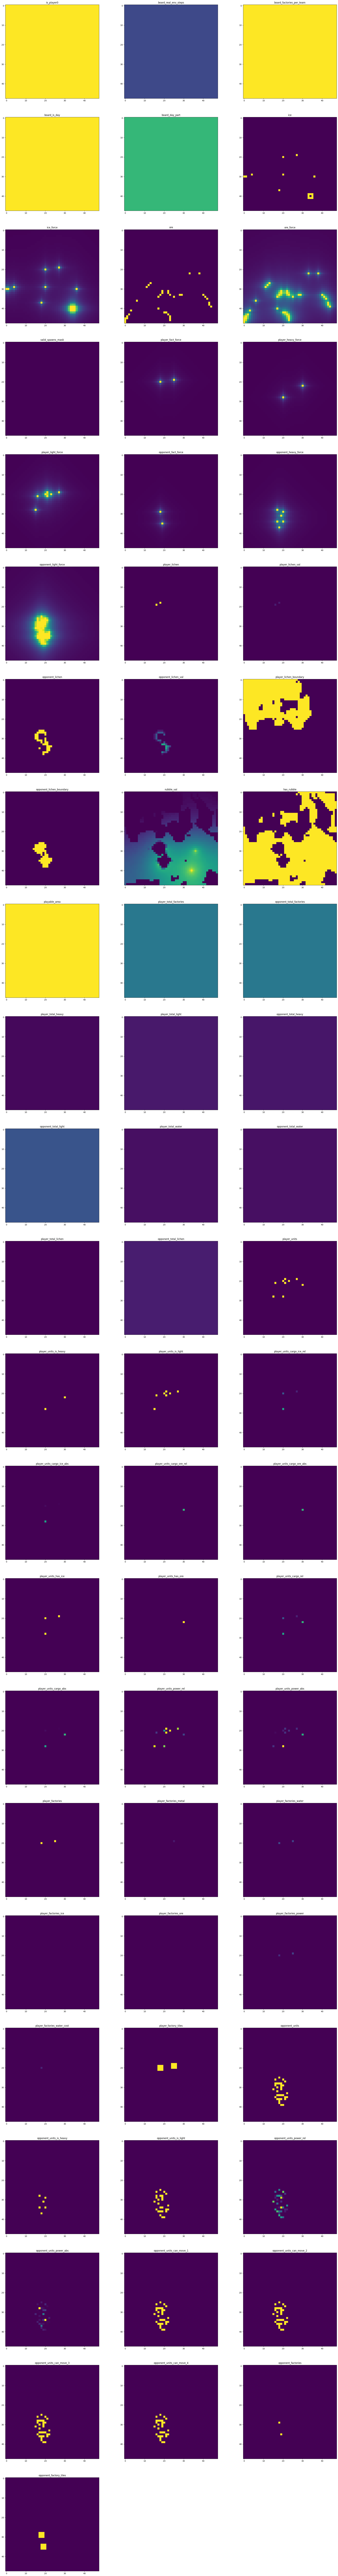

In [26]:
plot()

In [27]:
from tqdm import tqdm

seed_everything(42)

unit_class_sum = np.zeros((len(amaker.unit_actions),))
factory_class_sum = np.zeros((len(amaker.factory_actions),))
bid_class_sum = np.zeros((len(amaker.bid_actions),))



In [28]:
# ix_list = np.arange(len(hf1["phase"]))
# np.random.shuffle(ix_list)

# for current_compressed_step_ix in tqdm(ix_list[:int(len(ix_list)*config.weighting_rate)]):
#     current_step = extract_step_h5_lz4(hf1, current_compressed_step_ix)
#     player_id = None
#     for sid in SUBMISSION_IDS:
#         try:
#             player_id = current_step['subm_ids'].index(sid)
#             break
#         except ValueError:
#             continue
#     assert player_id is not None
#     player_name = f"player_{player_id}"
#     wgs = WrappedGameState2(env.env_cfg, current_step['step'], current_step)
#     t_p = amaker.inverse_actions(wgs, player_name, current_step['actions'][player_name])
#     unit_class_sum += t_p["unit"].sum(0).sum(0).numpy()
#     factory_class_sum += t_p["factory"].sum(0).sum(0).numpy()
#     bid_class_sum += t_p["bid"].numpy()
    
ix_list = np.arange(len(hf2["phase"]))
np.random.shuffle(ix_list)

for current_compressed_step_ix in tqdm(ix_list[:int(len(ix_list)*config.weighting_rate)]):
    current_step = extract_step_h5_lz4(hf2, current_compressed_step_ix)
    player_id = None
    for sid in SUBMISSION_IDS:
        try:
            player_id = current_step['subm_ids'].index(sid)
            break
        except ValueError:
            continue
    assert player_id is not None
    player_name = f"player_{player_id}"
    wgs = WrappedGameState2(env.env_cfg, current_step['step'], current_step)
    t_p = amaker.inverse_actions(wgs, player_name, current_step['actions'][player_name])
    unit_class_sum += t_p["unit"].sum(0).sum(0).numpy()
    factory_class_sum += t_p["factory"].sum(0).sum(0).numpy()
    bid_class_sum += t_p["bid"].numpy()

100%|██████████| 37118/37118 [01:34<00:00, 393.87it/s]


In [29]:
for ua, us in zip(amaker.unit_actions, unit_class_sum):
    print(ua, us)

unittype_move(HEAVY, 0) 143964.0
unittype_move(HEAVY, 1) 26475.0
unittype_move(HEAVY, 2) 23650.0
unittype_move(HEAVY, 3) 25506.0
unittype_move(HEAVY, 4) 23318.0
unittype_dig(HEAVY) 102814.0
unittype_transfer_cargo(HEAVY) 4516.0
unittype_transfer_power(HEAVY) 80.0
unittype_pickup_power(HEAVY) 17174.0
unittype_recharge(HEAVY) 0.0
unittype_move(LIGHT, 0) 208886.0
unittype_move(LIGHT, 1) 135520.0
unittype_move(LIGHT, 2) 124315.0
unittype_move(LIGHT, 3) 125643.0
unittype_move(LIGHT, 4) 123668.0
unittype_dig(LIGHT) 152178.0
unittype_transfer_cargo(LIGHT) 2329.0
unittype_transfer_power(LIGHT) 15174.0
unittype_pickup_power(LIGHT) 54942.0
unittype_recharge(LIGHT) 0.0


In [30]:
for fa, fs in zip(amaker.factory_actions, factory_class_sum):
    print(fa, fs)

factory_noop 52415.0
factory_build_heavy 673.0
factory_build_light 3425.0
factory_water 63712.0


In [31]:
for ba, bs in zip(amaker.bid_actions, bid_class_sum):
    print(ba, bs)

bid(0) 0.0
bid(10) 0.0
bid(20) 30.0


In [32]:
bid_class_mean_sum = np.mean( bid_class_sum )
unit_class_mean_sum = np.mean( unit_class_sum )
factory_class_mean_sum = np.mean( factory_class_sum )

In [33]:
unit_class_weights = unit_class_mean_sum / (unit_class_sum+1)
factory_class_weights = factory_class_mean_sum / (factory_class_sum+1)
bid_class_weights = bid_class_mean_sum / (bid_class_sum+1)

class_weights = dict(
    unit = unit_class_weights.clip(0.02, 50),
    factory = factory_class_weights.clip(0.02, 50),
    bid = bid_class_weights.clip(0.02, 50),
    placement = 1,
)

In [34]:
for ua, us, ucs in zip(amaker.unit_actions, class_weights["unit"], unit_class_sum):
    print(f"{ua}, {ucs}, {us:.2f}")
    
for ua, us, ucs in zip(amaker.factory_actions, class_weights["factory"], factory_class_sum):
    print(f"{ua}, {ucs}, {us:.2f}")


unittype_move(HEAVY, 0), 143964.0, 0.46
unittype_move(HEAVY, 1), 26475.0, 2.47
unittype_move(HEAVY, 2), 23650.0, 2.77
unittype_move(HEAVY, 3), 25506.0, 2.57
unittype_move(HEAVY, 4), 23318.0, 2.81
unittype_dig(HEAVY), 102814.0, 0.64
unittype_transfer_cargo(HEAVY), 4516.0, 14.50
unittype_transfer_power(HEAVY), 80.0, 50.00
unittype_pickup_power(HEAVY), 17174.0, 3.81
unittype_recharge(HEAVY), 0.0, 50.00
unittype_move(LIGHT, 0), 208886.0, 0.31
unittype_move(LIGHT, 1), 135520.0, 0.48
unittype_move(LIGHT, 2), 124315.0, 0.53
unittype_move(LIGHT, 3), 125643.0, 0.52
unittype_move(LIGHT, 4), 123668.0, 0.53
unittype_dig(LIGHT), 152178.0, 0.43
unittype_transfer_cargo(LIGHT), 2329.0, 28.11
unittype_transfer_power(LIGHT), 15174.0, 4.32
unittype_pickup_power(LIGHT), 54942.0, 1.19
unittype_recharge(LIGHT), 0.0, 50.00
factory_noop, 52415.0, 0.57
factory_build_heavy, 673.0, 44.59
factory_build_light, 3425.0, 8.77
factory_water, 63712.0, 0.47


In [35]:
from common.symmetric_layers_torch import SymmetricConv2d
from torch.distributions import Categorical, Multinomial
import torch.nn.functional as F
import torch
from torch import nn

def to_device(x, device, non_blocking=False):
    if isinstance(x, dict):
        return {k: to_device(v, device, non_blocking) for k, v in x.items()}
    return x.to(device, non_blocking=non_blocking)


class Transpose(nn.Module):
    def __init__(self, permutation):
        super().__init__()
        self.permutation = permutation

    def forward(self, x):
        return x.permute(self.permutation)

    

class Scaling(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Conv2d(in_features, in_features, 1, groups=in_features, bias=False)

    def forward(self, x):
        x = self.linear(x)
        return x
    

class Concat(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return torch.cat(x, dim=self.dim)
    

class ConvRelu(nn.Module):
    def __init__(self, in_chan, out_chan, size, batch_norm):
        super().__init__()
        self.residual_conv = nn.Conv2d(in_chan, out_chan, (size,size), padding="same")
        self.bn = nn.BatchNorm2d(out_chan) if batch_norm else nn.Identity(out_chan)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.bn(res)
        res = F.relu(res)
        return res

    
class ResidualDualConvRelu(nn.Module):
    def __init__(self, in_chan, size, batch_norm):
        super().__init__()
        self.residual_conv = nn.Conv2d(in_chan, in_chan, (size,size), padding="same")
        self.bn1 = nn.BatchNorm2d(in_chan) if batch_norm else nn.Identity(out_chan)
        self.residual_conv2 = nn.Conv2d(in_chan, in_chan, (size,size), padding="same")
        self.bn2 = nn.BatchNorm2d(in_chan) if batch_norm else nn.Identity(out_chan)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.bn1(res)
        res = F.relu(res)
        res = self.residual_conv2(res)
        res = self.bn2(res)
        res = res + x
        res = F.relu(res)
        return res


class FeatureExtractor(nn.Module):
    def __init__(self, in_chan, features, layers, batch_norm):
        super().__init__()
        self.blks = nn.Sequential(
            ConvRelu(in_chan, features, 1, batch_norm=batch_norm),
            *(ResidualDualConvRelu(features, 3, batch_norm=batch_norm) for _ in range(layers)),
        )

    def forward(self, state):
        return self.blks(state)

    
def estimate_loss_prob(pred, target, amask, cw):
    res = {}
    for k in pred:
        loss_grid = -pred[k].log() * target[k] * amask[k] * cw[k]
        # print(loss_grid.shape)
        loss = loss_grid.sum() / target[k].shape[0]
        res[k] = loss
    return res

    
def estimate_loss_logprob(logpred, target, amask, cw):
    res = {}
    for k in logpred:
        loss_grid = -logpred[k] * target[k] * amask[k] * cw[k]
        # print(loss_grid.shape)
        loss = loss_grid.sum() / target[k].shape[0]
        res[k] = loss
    return res

class ModelBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer("placeholder", torch.tensor(1e-5, requires_grad=False))
        self.register_buffer("neginf", torch.tensor(-1e20, dtype=torch.float, requires_grad=False))
        self.register_buffer("one", torch.tensor(1, dtype=torch.float, requires_grad=False))
        self.register_buffer("zero", torch.tensor(0, dtype=torch.float, requires_grad=False))
        self.register_buffer("smallfloat", torch.tensor(1e-45, dtype=torch.float, requires_grad=False))
        
    @torch.jit.export
    def forward(self, x_game, x_board):
        raise NotImplementedError
    
    def softmax_logprob(self, logits, amask):
        res = {}
        for k in logits:
            logits_masked = logits[k]
            logprobs = torch.log_softmax(logits_masked, dim=-1) # + self.placeholder
            res[k] = logprobs
        return res
    
    def softmax_raw(self, logits, amask):
        res = {}
        for k in logits:
            logits_masked = logits[k]
            probs = torch.softmax(logits_masked, dim=-1) # + self.placeholder
            res[k] = probs
        return res
    
    def softmax_masked(self, logits, amask):
        res = {}
        for k in logits:
            block_mask = amask[k].sum(-1, keepdims=True)>0
            logits_masked = torch.where(  torch.where( block_mask.bool(), amask[k], True ).bool(), logits[k], self.neginf)
            probs = torch.softmax(logits_masked, dim=-1) + self.placeholder
            res[k] = probs
        return res
    
    def softmax_logprob_masked(self, logits, amask):
        res = {}
        for k in logits:
#             block_mask = amask[k].sum(-1, keepdims=True)>0
            logits_masked = logits[k] + (amask[k] + self.smallfloat).log()
            logprobs = torch.log_softmax(logits_masked, dim=-1) # + self.placeholder
            res[k] = logprobs
        return res
    


In [36]:
class Policy_Bid(ModelBase):
    def __init__(self, in_channels_grid, in_channels_game, out_channels_unit, out_channels_factory, out_channels_bid):
        super().__init__()

        fe_bid_features = 16
        
        self.fe_bid = nn.Sequential(
            nn.Conv2d(in_channels_grid, 32, (1,1), padding="same"),
            nn.ReLU(),
            FeatureExtractor(32, fe_bid_features, 12, batch_norm=True)
        )

        self.policy_bid = nn.Sequential(
            nn.Conv2d(fe_bid_features, 1, (1, 1), padding="same"),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(48*48, out_channels_bid)
        )
    
    @torch.jit.export
    def forward(self, x_game, x_board):
        board = x_board.permute((0,3,1,2))
        fe_bid = self.fe_bid(board)
        logits_bid = self.policy_bid(fe_bid)
        return dict(
            bid=logits_bid, 
        )


class Policy_Placement(ModelBase):
    def __init__(self, in_channels_grid, in_channels_game, out_channels_unit, out_channels_factory, out_channels_bid):
        super().__init__()

        fe_placement_features = 16
        
        self.fe_placement = nn.Sequential(
            nn.Conv2d(in_channels_grid, 64, (1,1), padding="same" ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            FeatureExtractor(64, fe_placement_features, 24, batch_norm=True)
        )
        
        self.policy_placement = nn.Sequential(
            nn.Conv2d(fe_placement_features, 1, (1, 1), padding="same"),
            Transpose((0, 2, 3, 1)),
            nn.Flatten(),
        )

    @torch.jit.export
    def forward(self, x_game, x_board):
        board = x_board.permute((0,3,1,2))
        fe_placement = self.fe_placement(board)
        logits_placement = self.policy_placement(fe_placement)
        return dict(
            placement=logits_placement,
        )


class Policy_Game(ModelBase):
    def __init__(self, in_channels_grid, in_channels_game, out_channels_unit, out_channels_factory, out_channels_bid):
        super().__init__()

        fe_game_features = 64
        fe_f_features = 16

        self.fe_game = nn.Sequential(
            nn.Conv2d(in_channels_grid, 128, (1, 1), padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            FeatureExtractor(128, fe_game_features, 16, batch_norm=True)
        )

        self.fe_f = nn.Sequential(
            nn.Conv2d(in_channels_grid, 64, (1, 1), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            FeatureExtractor(64, fe_f_features, 12, batch_norm=True)
        )

        self.policy_unit = nn.Sequential(
            nn.Conv2d(fe_game_features, 64, (1, 1), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_channels_unit, (1, 1), padding="same"),
            Transpose((0, 2, 3, 1)),
        )

        self.policy_factory = nn.Sequential(
            nn.Conv2d(fe_f_features, 64, (1, 1), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_channels_factory, (1, 1), padding="same"),
            Transpose((0, 2, 3, 1)),
        )

    @torch.jit.export
    def forward(self, x_game, x_board):
        board = x_board.permute((0, 3, 1, 2))

        fe_game = self.fe_game(board)
        fe_f = self.fe_f(board)

        logits_unit = self.policy_unit(fe_game)
        logits_factory = self.policy_factory(fe_f)

        return dict(
            unit=logits_unit,
            factory=logits_factory,
        )




In [37]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, hf, indices, subm_ids):
        self.hf = hf
        self.indices = indices
        self.subm_ids = subm_ids
 
    def __len__(self):
        return len(self.indices)

    def __getitem__(self,idx):
        current_step = extract_step_h5_lz4(self.hf, self.indices[idx])
        
        player_id = None
        for sid in self.subm_ids:
            try:
                player_id = current_step['subm_ids'].index(sid)
                break
            except ValueError:
                continue
        assert player_id is not None
        
        player_name = f"player_{player_id}"
        opponent_id = 1 - player_id
        opponent_name = f"player_{opponent_id}"
        
        flip_x = random.random() < 0.5
        flip_y = random.random() < 0.5
        rot90 = random.random() < 0.5
        
        obs = current_step
        obs_t = flip_transform_obs_nocopy(obs, flip_x, flip_y, rot90)
        act_t = flip_transform_actions_nocopy(current_step['actions'][player_name], flip_x, flip_y, rot90)
            
        wgs = WrappedGameState2(env.env_cfg, current_step['step'], obs_t)
        
        o = fmaker.collect_features(wgs, player_name)
        am_p = amaker.make_actions_mask(wgs, player_name)
        t_p = amaker.inverse_actions(wgs, player_name, act_t)
        return dict(obs=o, amask=am_p, target=t_p) 
    

    
class MyDatasetMerge(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.ds_lens = [len(ds) for ds in datasets]
        self.total_len = sum(self.ds_lens)
 
    def __len__(self):
        return self.total_len

    def __getitem__(self,idx):
        idx_r = idx
        for ds, dsl in zip(self.datasets, self.ds_lens):
            if idx_r >= dsl:
                idx_r -= dsl
                continue
            return ds[idx_r]    
    
    
# from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import Pool


def to_numpy(x):
    if isinstance(x, dict):
        return {k: to_numpy(v) for k, v in x.items()}
    else:
        return x.numpy()

def to_torch(x):
    if isinstance(x, dict):
        return {k: to_torch(v) for k, v in x.items()}
    else:
        return torch.as_tensor(x)

def make_data(args):
    current_step_stc, subm_id, flip_x, flip_y, rot90 = args
    current_step = decompress_step(current_step_stc)
    player_id = current_step['subm_ids'].index(subm_id)
    player_name = f"player_{player_id}"
    opponent_id = 1 - player_id
    opponent_name = f"player_{opponent_id}"
    obs = current_step
    obs_t = flip_transform_obs_nocopy(obs, flip_x, flip_y, rot90)
    act_t = flip_transform_actions_nocopy(current_step['actions'][player_name], flip_x, flip_y, rot90)
    wgs = WrappedGameState2(env.env_cfg, current_step['step'], obs_t)

    o = fmaker.collect_features(wgs, player_name)
    am_p = amaker.make_actions_mask(wgs, player_name)
    t_p = amaker.inverse_actions(wgs, player_name, act_t)
    return dict(obs=to_numpy(o), amask=to_numpy(am_p), target=to_numpy(t_p))


class MyDatasetRaw(Dataset):
    def __init__(self, hf, indices, subm_id):
        self.hf = hf
        self.subm_id = subm_id
        
        tasks = []
        print("extracting")
        for idx in tqdm(indices):
            flip_x = 0
            flip_y = 0
            rot90 = 0
            z = extract_step_h5_lz4_compressed(self.hf, idx)
            # tasks.append(( z, self.subm_id, flip_x, flip_y, rot90))
            
            for flip_x in range(2):
                for flip_y in range(2):
                    for rot90 in range(2):
                        tasks.append(( z, self.subm_id, flip_x, flip_y, rot90))
        
        self.data = []
        with Pool(16) as pool:
            for result in tqdm(pool.imap_unordered(make_data, tasks), total=len(tasks)):
                self.data += [to_torch(result)]
            
        print(len(self.data))
 
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

In [38]:
def _report(lbl, TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    report = {'label': lbl, 
              'Precision': PPV,
              'Recall': TPR, 
              'Sensitivity': TPR,
              'Specificity': TNR,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR+0.0001),
              'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 
              'TPR': TPR, 
              'TNR' : TNR, 
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 
             }
    return report

def multi_classification_report(conf_mat, labels=None, as_frame=False):
    """
    Args:
        y_true (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame
        
    Return:
        report (dict)
    """
    
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels
        
    TOTAL_SUM = conf_mat.sum()
    for i, name in enumerate(counter):
        TP = conf_mat[i,i]
        FP = conf_mat[:,i].sum() - TP
        FN = conf_mat[i,:].sum() - TP
        TN = TOTAL_SUM - FP - FN - TP
        rep =  _report(name, TN, FP, FN, TP)
        report[name] = rep
    
    if as_frame:
        return pd.DataFrame(report).T
    return report

In [39]:
# import resource
# rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
# resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))
# torch.multiprocessing.set_sharing_strategy('file_system')

In [40]:
dataset_dict = {}

seed_everything(42)

for phase in [0,1,2]:
#     ix_list = [ei for ei, p in enumerate(hf1["phase"][:]) if p == phase]
#     np.random.shuffle(ix_list)
#     ix_list = ix_list[:config.DATASET_LIMIT]
#     ts_len = int(len(ix_list) * 0.1)
#     print(phase, len(ix_list), ts_len)

#     ds_train1 = MyDataset(hf1, ix_list[:-ts_len], SUBMISSION_IDS)
#     ds_test1 = MyDataset(hf1, ix_list[-ts_len:], SUBMISSION_IDS)
    
    ix_list = [ei for ei, p in enumerate(hf2["phase"][:]) if p == phase]
    np.random.shuffle(ix_list)
    ix_list = ix_list[:config.DATASET_LIMIT]
    ts_len = int(len(ix_list) * 0.1)
    print(phase, len(ix_list), ts_len)

    ds_train2 = MyDataset(hf2, ix_list[:-ts_len], SUBMISSION_IDS)
    ds_test2 = MyDataset(hf2, ix_list[-ts_len:], SUBMISSION_IDS)
    
    ds_train = MyDatasetMerge([ds_train2])
    ds_test = MyDatasetMerge([ds_test2])
        
    dataset_dict[phase] = (ds_train, ds_test)

0 761 76
1 5232 523
2 736382 73638


In [41]:
def train_epoch(epoch_i, policy, optimizer, scaler, loader, cw, key):
    t_start = time.time()
    amp_enabled = amp_dtype in (torch.float16, torch.bfloat16)
    
    print('loader', len(loader))
    policy.train()

    total_loss_by_type = defaultdict(float)
    total_loss_avg_by_type = defaultdict(float)
    rolling_loss_by_type = defaultdict(float)
    rolling_loss_avg_by_type = defaultdict(float)
    rolling_t = time.time()

    roll_wnd = 100

    for batch_i, data in enumerate(tqdm(loader)):
        obs = to_device(data["obs"], device, True)
        amask = to_device(data["amask"], device, True)
        target = to_device(data["target"], device, True)
        
        target_amask_sum = {k: (target[k]*amask[k]).sum().item() + 0.01 for k in target}
        # zero the parameter gradients
        optimizer.zero_grad()

        with autocast(enabled=amp_enabled, dtype=amp_dtype):
            logits = policy.forward(obs["game"], obs["board"])
            logprobs = policy.softmax_masked(logits, amask)
            loss_by_type = estimate_loss_prob(logprobs, target, amask, cw)
            
        loss = 0
        for k in loss_by_type:
            loss += loss_by_type[k] * target[k].shape[0]/target_amask_sum[k]
            
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(policy.parameters(), 1)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(policy.parameters(), 1)
            optimizer.step()

        # print statistics
        batch_loss_by_type = {k: v.item() for k, v in loss_by_type.items()}
        for k, v in batch_loss_by_type.items():
            total_loss_by_type[k] += v
            total_loss_avg_by_type[k] += v * target[k].shape[0]/target_amask_sum[k]
            rolling_loss_by_type[k] += v
            rolling_loss_avg_by_type[k] += v * target[k].shape[0]/target_amask_sum[k]

        if (batch_i+1) % roll_wnd == 0:
            rolling_stats = {}
            rolling_stats[f'{key}/stats/duration'] = time.time() - rolling_t
            for k, v in rolling_loss_by_type.items():
                rolling_stats[f'{key}/loss/{k}'] = v/roll_wnd
            for k, v in rolling_loss_avg_by_type.items():
                rolling_stats[f'{key}/loss_avg/{k}'] = v/roll_wnd
                
            print("loss", batch_i, rolling_stats)
            rolling_loss_by_type = defaultdict(float)
            rolling_loss_avg_by_type = defaultdict(float)
            rolling_t = time.time()


    out_stats = {}
    out_stats[f'{key}/stats/epoch_duration'] = time.time() - t_start
    for k, v in total_loss_by_type.items():
        out_stats[f'{key}/loss/{k}'] = v/len(loader)
    for k, v in total_loss_avg_by_type.items():
        out_stats[f'{key}/loss_avg/{k}'] = v/len(loader)
    print(out_stats)
    return out_stats


@torch.no_grad()
def eval_epoch(epoch_i, policy, loader, cw, class_labels, key):
    t_start = time.time()
    
    print('loader', len(loader), 'bs')
    policy.eval()
    
    total_loss_by_type = defaultdict(float)
    total_loss_avg_by_type = defaultdict(float)
    rolling_loss_by_type = defaultdict(float)
    rolling_loss_avg_by_type = defaultdict(float)
    rolling_t = time.time()

    total_confusion_mat_dict = {}
    for k, v in class_labels.items():
        total_confusion_mat_dict[k] = np.zeros((len(v), len(v)), dtype=int)

    roll_wnd = 100

    for batch_i, data in enumerate(tqdm(loader)):
        obs = to_device(data["obs"], device, True)
        amask = to_device(data["amask"], device, True)
        target = to_device(data["target"], device, True)
        target_amask_sum = {k: (target[k]*amask[k]).sum().item() + 0.01 for k in target}

        logits = policy.forward(obs["game"], obs["board"])
        logprobs = policy.softmax_masked(logits, amask)
        loss_by_type = estimate_loss_prob(logprobs, target, amask, cw)

        loss = 0
        for k in loss_by_type:
            loss += loss_by_type[k] * target[k].shape[0]/target_amask_sum[k]

        # print statistics
        batch_loss_by_type = {k: v.item() for k, v in loss_by_type.items()}
        for k, v in batch_loss_by_type.items():
            total_loss_by_type[k] += v
            total_loss_avg_by_type[k] += v * target[k].shape[0]/target_amask_sum[k]
            rolling_loss_by_type[k] += v
            rolling_loss_avg_by_type[k] += v * target[k].shape[0]/target_amask_sum[k]

        for k, mat in total_confusion_mat_dict.items():
            probs_argmax_unit = torch.argmax(logprobs[k], dim=-1)
            target_argmax_unit = torch.argmax(target[k] * amask[k], dim=-1)
            target_unit = target[k]
            block_mask_unit = target[k].sum(-1)>0
            active_units = torch.argwhere(block_mask_unit)
            for i, x, y in active_units:
                pred = probs_argmax_unit[i,x,y]
                tgt  = target_argmax_unit[i,x,y]
                mat[tgt, pred] += 1

        if (batch_i+1) % roll_wnd == 0:
            rolling_stats = {}
            rolling_stats[f'{key}/stats/roll_duration'] = time.time() - rolling_t
            for k, v in rolling_loss_by_type.items():
                rolling_stats[f'{key}/loss/{k}'] = v/roll_wnd
            for k, v in rolling_loss_avg_by_type.items():
                rolling_stats[f'{key}/loss_avg/{k}'] = v/roll_wnd
            print("loss", batch_i, rolling_stats)
            rolling_loss_by_type = defaultdict(float)
            rolling_loss_avg_by_type = defaultdict(float)
            rolling_t = time.time()

    out_stats = {}
    out_stats[f'{key}/stats/epoch_duration'] = time.time() - t_start
    for k, v in total_loss_by_type.items():
        out_stats[f'{key}/loss/{k}'] = v/len(loader)
    for k, v in total_loss_avg_by_type.items():
        out_stats[f'{key}/loss_avg/{k}'] = v/len(loader)
    print(out_stats)
    
    for k, mat in total_confusion_mat_dict.items():
        # if np.sum(m) == 0:
        #     continue
    
        print(k)
        print(mat)

        if k not in class_labels:
            continue
            
        df = multi_classification_report(mat, class_labels[k], True)
        out_stats[f'{key}/report/{k}'] = df

    return out_stats


In [42]:


def train_policy_bid():
    gc.collect()
    torch.cuda.empty_cache()
    
    seed_everything(42)
    
    ds_train, ds_test = dataset_dict[0]
    
    X_train_loader = DataLoader(ds_train, batch_size=config.batch_size_bid, shuffle=True, num_workers=14, prefetch_factor=2, pin_memory=True)
    X_test_loader = DataLoader(ds_test, batch_size=config.batch_size_bid, shuffle=False, num_workers=14, prefetch_factor=2, pin_memory=True)

    obs_spec = fmaker.get_obs_spec()
    policy_bid = Policy_Bid(obs_spec["board"].shape[-1],
                          obs_spec["game"].shape[-1],
                          len(amaker.unit_actions),
                          len(amaker.factory_actions),
                          len(amaker.bid_actions)).to(device)

    optimizer = optim.Adam(policy_bid.parameters(), lr=config.lr_bid, eps=EPS)  
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.lr_gamma_bid)
    scaler = GradScaler()

    np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
    cw = {k:torch.as_tensor(v, dtype=torch_dtype).to(device) for k, v in class_weights.items()}

    try:
        if USE_WANDB:
            wandb.init(project=proj_name, id=net_suffix + "_bid", config=config)
            wandb.watch(policy_bid, log='all', log_graph=True, log_freq=100)

        for epoch in range(config.epochs_bid):  # loop over the dataset multiple times
            lr = float(scheduler.get_last_lr()[0])
            stats = dict(lr=lr)
            print(f"epoch {epoch} lr {lr}")

            # with torch.autograd.detect_anomaly():
            stats.update(train_epoch(epoch, policy_bid, optimizer, scaler, X_train_loader, cw, "train"))

            with torch.no_grad():
                stats.update(eval_epoch(epoch, policy_bid, X_test_loader, cw, {}, "test"))

            print({k:v for k, v in stats.items() if 'report/' not in k})
            if USE_WANDB:
                wandb.log(stats, step=epoch, commit=True)
                
            scheduler.step()

            if True: #epoch % 5 == 0:
                with atomic_write(os.path.join(storage_dir, f"policy_bid.{net_suffix}.{epoch}.pty"), overwrite=True, mode='wb') as out_f:
                    torch.save({"model": policy_bid.state_dict(), "optimizer": optimizer.state_dict() }, out_f)

    finally:
        if USE_WANDB:
            wandb.finish()
            
if config.train_bid:
    train_policy_bid()

In [43]:

def train_policy_placement():
    gc.collect()
    torch.cuda.empty_cache()
    
    seed_everything(42)
    
    ds_train, ds_test = dataset_dict[1]
    
    X_train_loader = DataLoader(ds_train, batch_size=config.batch_size_placement, shuffle=True, num_workers=14, prefetch_factor=2, pin_memory=True)
    X_test_loader = DataLoader(ds_test, batch_size=config.batch_size_placement, shuffle=False, num_workers=14, prefetch_factor=2, pin_memory=True)

    obs_spec = fmaker.get_obs_spec()
    policy_placement = Policy_Placement(obs_spec["board"].shape[-1],
                          obs_spec["game"].shape[-1],
                          len(amaker.unit_actions),
                          len(amaker.factory_actions),
                          len(amaker.bid_actions)).to(device)

    optimizer = optim.Adam(policy_placement.parameters(), lr=config.lr_placement, eps=EPS)  
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.lr_gamma_placement)
    scaler = GradScaler()

    np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
    cw = {k:torch.as_tensor(v, dtype=torch_dtype).to(device) for k, v in class_weights.items()}

    try:
        if USE_WANDB:
            wandb.init(project=proj_name, id=net_suffix + "_placement", config=config)
            wandb.watch(policy_placement, log='all', log_graph=True, log_freq=600)

        for epoch in range(config.epochs_placement):  # loop over the dataset multiple times
            lr = float(scheduler.get_last_lr()[0])
            stats = dict(lr=lr)
            print(f"epoch {epoch} lr {lr}")
            
            # with torch.autograd.detect_anomaly():
            stats.update(train_epoch(epoch, policy_placement, optimizer, scaler, X_train_loader, cw, "train"))

            with torch.no_grad():
                stats.update(eval_epoch(epoch, policy_placement, X_test_loader, cw, {}, "test"))

            print({k:v for k, v in stats.items() if 'report/' not in k})
            if USE_WANDB:
                wandb.log(stats, step=epoch, commit=True)

            scheduler.step()
                
            if True: #epoch % 5 == 0:
                with atomic_write(os.path.join(storage_dir, f"policy_placement.{net_suffix}.{epoch}.pty"), overwrite=True, mode='wb') as out_f:
                    torch.save({"model": policy_placement.state_dict(), "optimizer": optimizer.state_dict() }, out_f)

    finally:
        if USE_WANDB:
            wandb.finish()

            
if config.train_placement:
    train_policy_placement()

In [ ]:

def train_policy_game():
    gc.collect()
    torch.cuda.empty_cache()
    
    seed_everything(42)
    
    ds_train, ds_test = dataset_dict[2]
    
    X_train_loader = DataLoader(ds_train, batch_size=config.batch_size_game, shuffle=True, num_workers=14, prefetch_factor=2, pin_memory=True)
    X_test_loader = DataLoader(ds_test, batch_size=config.batch_size_game, shuffle=False, num_workers=14, prefetch_factor=2, pin_memory=True)

    obs_spec = fmaker.get_obs_spec()
    policy_game = Policy_Game(obs_spec["board"].shape[-1],
                          obs_spec["game"].shape[-1],
                          len(amaker.unit_actions),
                          len(amaker.factory_actions),
                          len(amaker.bid_actions),
                             )

    if config.game_load_from:
        with open(config.game_load_from, 'rb') as in_f:
            checkpoint = torch.load(in_f, map_location="cpu")
            policy_game.load_state_dict(checkpoint["model"])
    
    policy_game.to(device)
    
    optimizer = optim.Adam(policy_game.parameters(), lr=config.lr_game, eps=EPS)  
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.lr_gamma_game)
    scaler = GradScaler()

    np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
    cw = {k:torch.as_tensor(v, dtype=torch_dtype).to(device) for k, v in class_weights.items()}

    try:
        if USE_WANDB:
            wandb.init(project=proj_name, id=net_suffix + "_game", config=config)
            wandb.watch(policy_game, log='all', log_graph=True, log_freq=1000)

        for epoch in range(config.epochs_game):  # loop over the dataset multiple times
            lr = float(scheduler.get_last_lr()[0])
            stats = dict(lr=lr)
            print(f"epoch {epoch} lr {lr}")
            
            # with torch.autograd.detect_anomaly():
            stats.update(train_epoch(epoch, policy_game, optimizer, scaler, X_train_loader, cw, "train" ))

            with torch.no_grad():
                stats.update(eval_epoch(epoch, policy_game, X_test_loader, cw, {"unit": [repr(x) for x in amaker.unit_actions], "factory": [repr(x) for x in amaker.factory_actions]}, "test"))

            print({k:v for k, v in stats.items() if 'report/' not in k})
            
            if USE_WANDB:
                wandb.log(stats, step=epoch, commit=True)

            scheduler.step()
                
            if True: #epoch % 5 == 0:
                with atomic_write(os.path.join(storage_dir, f"policy_game.{net_suffix}.{epoch}.pty"), overwrite=True, mode='wb') as out_f:
                    torch.save({"model": policy_game.state_dict(), "optimizer": optimizer.state_dict() }, out_f)

    finally:
        if USE_WANDB:
            wandb.finish()

            
if config.train_game:
    train_policy_game()

wandb: Currently logged in as: skyramp. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


epoch 0 lr 0.003
loader 10356


  1%|          | 101/10356 [00:13<19:25,  8.80it/s]

loss 99 {'train/stats/duration': 13.774423599243164, 'train/loss/unit': 46.06070907592773, 'train/loss/factory': 2.1049875712394712, 'train/loss_avg/unit': 1.2905190052032756, 'train/loss_avg/factory': 0.6488165419265133}


  2%|▏         | 200/10356 [00:25<17:36,  9.61it/s]

loss 199 {'train/stats/duration': 11.503623247146606, 'train/loss/unit': 33.15851621627807, 'train/loss/factory': 2.0048550868034365, 'train/loss_avg/unit': 0.9531008727455356, 'train/loss_avg/factory': 0.6165690182638867}


  3%|▎         | 302/10356 [00:36<16:55,  9.90it/s]

loss 299 {'train/stats/duration': 10.8349130153656, 'train/loss/unit': 31.364377975463867, 'train/loss/factory': 1.958662223815918, 'train/loss_avg/unit': 0.8821747155199822, 'train/loss_avg/factory': 0.6062704685025291}


  4%|▍         | 401/10356 [00:47<19:18,  8.59it/s]

loss 399 {'train/stats/duration': 11.273050546646118, 'train/loss/unit': 29.49032543182373, 'train/loss/factory': 1.9358756244182587, 'train/loss_avg/unit': 0.8384155819659789, 'train/loss_avg/factory': 0.594273581581577}


  5%|▍         | 502/10356 [00:58<16:57,  9.68it/s]

loss 499 {'train/stats/duration': 11.115197896957397, 'train/loss/unit': 28.56742328643799, 'train/loss/factory': 1.8783143556118012, 'train/loss_avg/unit': 0.8084412933180957, 'train/loss_avg/factory': 0.581466303860203}


  6%|▌         | 601/10356 [01:09<16:44,  9.72it/s]

loss 599 {'train/stats/duration': 10.845869302749634, 'train/loss/unit': 27.830383548736574, 'train/loss/factory': 1.9427146577835084, 'train/loss_avg/unit': 0.793374221631168, 'train/loss_avg/factory': 0.5974317691431696}


  7%|▋         | 701/10356 [01:20<17:18,  9.30it/s]

loss 699 {'train/stats/duration': 10.83724331855774, 'train/loss/unit': 27.314053993225098, 'train/loss/factory': 1.8635422325134277, 'train/loss_avg/unit': 0.7730447439181434, 'train/loss_avg/factory': 0.578582722780868}


  8%|▊         | 802/10356 [01:31<16:02,  9.93it/s]

loss 799 {'train/stats/duration': 10.963773250579834, 'train/loss/unit': 27.55871280670166, 'train/loss/factory': 1.8888564097881317, 'train/loss_avg/unit': 0.773961731864282, 'train/loss_avg/factory': 0.5830471800451166}


  9%|▊         | 901/10356 [01:42<18:16,  8.62it/s]

loss 899 {'train/stats/duration': 11.638922691345215, 'train/loss/unit': 26.669949989318848, 'train/loss/factory': 1.8955923581123353, 'train/loss_avg/unit': 0.7548820345054053, 'train/loss_avg/factory': 0.5841842615972525}


 10%|▉         | 1001/10356 [01:54<18:45,  8.31it/s]

loss 999 {'train/stats/duration': 11.218853950500488, 'train/loss/unit': 26.090282020568846, 'train/loss/factory': 1.8659334993362426, 'train/loss_avg/unit': 0.740605748343794, 'train/loss_avg/factory': 0.5799303307017937}


 11%|█         | 1101/10356 [02:05<18:33,  8.31it/s]

loss 1099 {'train/stats/duration': 11.495983600616455, 'train/loss/unit': 26.510317630767823, 'train/loss/factory': 1.856494380235672, 'train/loss_avg/unit': 0.7346441015190325, 'train/loss_avg/factory': 0.5729242967415235}


 12%|█▏        | 1201/10356 [02:16<16:35,  9.20it/s]

loss 1199 {'train/stats/duration': 11.046599626541138, 'train/loss/unit': 25.68499364852905, 'train/loss/factory': 1.8337616622447968, 'train/loss_avg/unit': 0.7311238313302023, 'train/loss_avg/factory': 0.5698850854282437}


 13%|█▎        | 1301/10356 [02:27<15:59,  9.44it/s]

loss 1299 {'train/stats/duration': 10.92665982246399, 'train/loss/unit': 24.93079767227173, 'train/loss/factory': 1.835575326681137, 'train/loss_avg/unit': 0.720201071160018, 'train/loss_avg/factory': 0.5730568510631732}


 14%|█▎        | 1401/10356 [02:38<16:59,  8.78it/s]

loss 1399 {'train/stats/duration': 10.960434436798096, 'train/loss/unit': 25.48329837799072, 'train/loss/factory': 1.8760070526599884, 'train/loss_avg/unit': 0.7164649676705355, 'train/loss_avg/factory': 0.5784838410676697}


 14%|█▍        | 1501/10356 [02:49<16:50,  8.76it/s]

loss 1499 {'train/stats/duration': 11.096524953842163, 'train/loss/unit': 25.65616107940674, 'train/loss/factory': 1.8435340237617492, 'train/loss_avg/unit': 0.7117873414948341, 'train/loss_avg/factory': 0.5685057111774061}


 15%|█▌        | 1601/10356 [03:00<15:48,  9.23it/s]

loss 1599 {'train/stats/duration': 10.966653823852539, 'train/loss/unit': 24.693581733703613, 'train/loss/factory': 1.847508407831192, 'train/loss_avg/unit': 0.7103385643146024, 'train/loss_avg/factory': 0.5690104365086569}


 16%|█▋        | 1701/10356 [03:11<15:12,  9.48it/s]

loss 1699 {'train/stats/duration': 10.906217813491821, 'train/loss/unit': 24.994047946929932, 'train/loss/factory': 1.8495120406150818, 'train/loss_avg/unit': 0.7039945381223243, 'train/loss_avg/factory': 0.5731090139160088}


 17%|█▋        | 1801/10356 [03:22<15:13,  9.37it/s]

loss 1799 {'train/stats/duration': 10.859911680221558, 'train/loss/unit': 24.828716888427735, 'train/loss/factory': 1.8220082640647888, 'train/loss_avg/unit': 0.702464058790141, 'train/loss_avg/factory': 0.5626077415026174}


 18%|█▊        | 1901/10356 [03:33<14:51,  9.49it/s]

loss 1899 {'train/stats/duration': 10.830679893493652, 'train/loss/unit': 24.25622476577759, 'train/loss/factory': 1.8186447274684907, 'train/loss_avg/unit': 0.6849331782657733, 'train/loss_avg/factory': 0.5607164848312916}


 19%|█▉        | 2002/10356 [03:44<15:33,  8.95it/s]

loss 1999 {'train/stats/duration': 10.991280317306519, 'train/loss/unit': 24.743056087493898, 'train/loss/factory': 1.8398343086242677, 'train/loss_avg/unit': 0.696330896307681, 'train/loss_avg/factory': 0.5670045455090452}


 20%|██        | 2101/10356 [03:55<16:31,  8.32it/s]

loss 2099 {'train/stats/duration': 10.777472019195557, 'train/loss/unit': 24.79485719680786, 'train/loss/factory': 1.8057805597782135, 'train/loss_avg/unit': 0.7015744806546376, 'train/loss_avg/factory': 0.5548354041276893}


 21%|██▏       | 2201/10356 [04:06<15:10,  8.96it/s]

loss 2199 {'train/stats/duration': 11.232047319412231, 'train/loss/unit': 24.48675775527954, 'train/loss/factory': 1.844557716846466, 'train/loss_avg/unit': 0.6920587627141547, 'train/loss_avg/factory': 0.5672326501785898}


 22%|██▏       | 2301/10356 [04:17<15:36,  8.60it/s]

loss 2299 {'train/stats/duration': 11.220027446746826, 'train/loss/unit': 24.517171325683595, 'train/loss/factory': 1.8357107639312744, 'train/loss_avg/unit': 0.6882080933265756, 'train/loss_avg/factory': 0.5644248502729495}


 23%|██▎       | 2401/10356 [04:28<14:52,  8.92it/s]

loss 2399 {'train/stats/duration': 11.154921293258667, 'train/loss/unit': 24.088121204376222, 'train/loss/factory': 1.832860847711563, 'train/loss_avg/unit': 0.6779241016922208, 'train/loss_avg/factory': 0.5625340351824695}


 24%|██▍       | 2501/10356 [04:39<14:37,  8.95it/s]

loss 2499 {'train/stats/duration': 11.322192668914795, 'train/loss/unit': 23.498981342315673, 'train/loss/factory': 1.8051223850250244, 'train/loss_avg/unit': 0.6752730598206143, 'train/loss_avg/factory': 0.5575141591700937}


 25%|██▌       | 2601/10356 [04:50<14:59,  8.62it/s]

loss 2599 {'train/stats/duration': 10.996763467788696, 'train/loss/unit': 24.012049903869627, 'train/loss/factory': 1.8067402863502502, 'train/loss_avg/unit': 0.6853210330589354, 'train/loss_avg/factory': 0.5538256058841964}


 26%|██▌       | 2701/10356 [05:01<13:55,  9.17it/s]

loss 2699 {'train/stats/duration': 10.95430064201355, 'train/loss/unit': 23.578766918182374, 'train/loss/factory': 1.8189283037185668, 'train/loss_avg/unit': 0.6679725953382142, 'train/loss_avg/factory': 0.5634739520074027}


 27%|██▋       | 2801/10356 [05:12<12:29, 10.08it/s]

loss 2799 {'train/stats/duration': 10.912575721740723, 'train/loss/unit': 23.885889873504638, 'train/loss/factory': 1.810744434595108, 'train/loss_avg/unit': 0.679610933733292, 'train/loss_avg/factory': 0.5591018416830522}


 28%|██▊       | 2901/10356 [05:23<14:14,  8.73it/s]

loss 2899 {'train/stats/duration': 11.132882118225098, 'train/loss/unit': 23.46283374786377, 'train/loss/factory': 1.8043806314468385, 'train/loss_avg/unit': 0.6655747255963491, 'train/loss_avg/factory': 0.5568943573608606}


 29%|██▉       | 3001/10356 [05:35<15:39,  7.83it/s]

loss 2999 {'train/stats/duration': 11.69572401046753, 'train/loss/unit': 23.380438594818116, 'train/loss/factory': 1.833750525712967, 'train/loss_avg/unit': 0.6663409325589025, 'train/loss_avg/factory': 0.5651306004175758}


 30%|██▉       | 3101/10356 [05:46<13:05,  9.24it/s]

loss 3099 {'train/stats/duration': 11.34199857711792, 'train/loss/unit': 23.37586170196533, 'train/loss/factory': 1.8523267805576324, 'train/loss_avg/unit': 0.6675863088936821, 'train/loss_avg/factory': 0.5719477756217328}


 31%|███       | 3201/10356 [05:58<13:58,  8.54it/s]

loss 3199 {'train/stats/duration': 11.061728477478027, 'train/loss/unit': 23.865799770355224, 'train/loss/factory': 1.8367784094810486, 'train/loss_avg/unit': 0.6734504596793249, 'train/loss_avg/factory': 0.5699540070929879}


 32%|███▏      | 3301/10356 [06:09<13:21,  8.80it/s]

loss 3299 {'train/stats/duration': 11.098214626312256, 'train/loss/unit': 23.461710147857666, 'train/loss/factory': 1.817966183423996, 'train/loss_avg/unit': 0.6633751869780243, 'train/loss_avg/factory': 0.5645543844625069}


 33%|███▎      | 3401/10356 [06:20<12:03,  9.61it/s]

loss 3399 {'train/stats/duration': 11.4924635887146, 'train/loss/unit': 23.849893379211426, 'train/loss/factory': 1.8283642101287843, 'train/loss_avg/unit': 0.6641137670190698, 'train/loss_avg/factory': 0.5612630052283908}


 34%|███▍      | 3501/10356 [06:32<14:02,  8.14it/s]

loss 3499 {'train/stats/duration': 11.635347604751587, 'train/loss/unit': 23.190421485900877, 'train/loss/factory': 1.8093886530399323, 'train/loss_avg/unit': 0.6562850917163042, 'train/loss_avg/factory': 0.5578507128325512}


 35%|███▍      | 3601/10356 [06:43<12:18,  9.15it/s]

loss 3599 {'train/stats/duration': 11.218246936798096, 'train/loss/unit': 23.380221118927, 'train/loss/factory': 1.7886465537548064, 'train/loss_avg/unit': 0.6567719449522353, 'train/loss_avg/factory': 0.5532083044726708}


 36%|███▌      | 3701/10356 [06:54<12:53,  8.60it/s]

loss 3699 {'train/stats/duration': 10.817860126495361, 'train/loss/unit': 23.236203479766846, 'train/loss/factory': 1.8347375726699828, 'train/loss_avg/unit': 0.6529351707631987, 'train/loss_avg/factory': 0.565859857683851}


 37%|███▋      | 3800/10356 [07:05<11:52,  9.20it/s]

loss 3799 {'train/stats/duration': 11.43963623046875, 'train/loss/unit': 23.48535779953003, 'train/loss/factory': 1.8038528656959534, 'train/loss_avg/unit': 0.653362374631929, 'train/loss_avg/factory': 0.5529845536416742}


 38%|███▊      | 3901/10356 [07:17<11:29,  9.36it/s]

loss 3899 {'train/stats/duration': 11.285661220550537, 'train/loss/unit': 23.109727764129637, 'train/loss/factory': 1.7992736780643463, 'train/loss_avg/unit': 0.6447716925758442, 'train/loss_avg/factory': 0.5579440767174242}


 39%|███▊      | 4002/10356 [07:28<11:34,  9.15it/s]

loss 3999 {'train/stats/duration': 11.166574954986572, 'train/loss/unit': 23.314995403289796, 'train/loss/factory': 1.7798376297950744, 'train/loss_avg/unit': 0.6560567884825751, 'train/loss_avg/factory': 0.5448230070266379}


 40%|███▉      | 4102/10356 [07:39<11:09,  9.34it/s]

loss 4099 {'train/stats/duration': 10.822442770004272, 'train/loss/unit': 22.819015884399413, 'train/loss/factory': 1.7898532021045686, 'train/loss_avg/unit': 0.6591796984538619, 'train/loss_avg/factory': 0.5514780719411267}


 41%|████      | 4201/10356 [07:50<12:14,  8.38it/s]

loss 4199 {'train/stats/duration': 11.159366369247437, 'train/loss/unit': 22.987503967285157, 'train/loss/factory': 1.8367141306400299, 'train/loss_avg/unit': 0.648283289868438, 'train/loss_avg/factory': 0.564669571638226}


 42%|████▏     | 4301/10356 [08:01<11:46,  8.57it/s]

loss 4299 {'train/stats/duration': 11.290752410888672, 'train/loss/unit': 22.938980178833006, 'train/loss/factory': 1.8159709763526917, 'train/loss_avg/unit': 0.6398979433123988, 'train/loss_avg/factory': 0.5598914341293212}


 42%|████▏     | 4400/10356 [08:12<09:37, 10.31it/s]

loss 4399 {'train/stats/duration': 10.907324075698853, 'train/loss/unit': 23.218810310363768, 'train/loss/factory': 1.7834389734268188, 'train/loss_avg/unit': 0.6532947236021528, 'train/loss_avg/factory': 0.5471005240247476}


 43%|████▎     | 4502/10356 [08:23<10:42,  9.12it/s]

loss 4499 {'train/stats/duration': 11.22223162651062, 'train/loss/unit': 22.785474720001222, 'train/loss/factory': 1.7867019391059875, 'train/loss_avg/unit': 0.6481578375684464, 'train/loss_avg/factory': 0.5488231305491129}


 44%|████▍     | 4600/10356 [08:34<10:13,  9.38it/s]

loss 4599 {'train/stats/duration': 10.853797197341919, 'train/loss/unit': 22.71821891784668, 'train/loss/factory': 1.7775719571113586, 'train/loss_avg/unit': 0.6460497516873869, 'train/loss_avg/factory': 0.5553008201816123}


 45%|████▌     | 4701/10356 [08:45<10:31,  8.95it/s]

loss 4699 {'train/stats/duration': 10.794992923736572, 'train/loss/unit': 22.929924697875975, 'train/loss/factory': 1.7886054575443269, 'train/loss_avg/unit': 0.6433243158405143, 'train/loss_avg/factory': 0.5470831647087978}


 46%|████▋     | 4801/10356 [08:56<11:10,  8.29it/s]

loss 4799 {'train/stats/duration': 11.138572216033936, 'train/loss/unit': 22.534710941314696, 'train/loss/factory': 1.7996784687042235, 'train/loss_avg/unit': 0.641019125753557, 'train/loss_avg/factory': 0.5526201814527358}


 47%|████▋     | 4901/10356 [09:07<09:45,  9.32it/s]

loss 4899 {'train/stats/duration': 10.9472336769104, 'train/loss/unit': 22.782012825012206, 'train/loss/factory': 1.8029630088806152, 'train/loss_avg/unit': 0.646280737307391, 'train/loss_avg/factory': 0.5571025900425552}


 48%|████▊     | 5001/10356 [09:18<11:38,  7.66it/s]

loss 4999 {'train/stats/duration': 11.283276319503784, 'train/loss/unit': 23.046716022491456, 'train/loss/factory': 1.8245364785194398, 'train/loss_avg/unit': 0.6443364569334313, 'train/loss_avg/factory': 0.5606540570177044}


 49%|████▉     | 5101/10356 [09:29<09:47,  8.95it/s]

loss 5099 {'train/stats/duration': 11.204467535018921, 'train/loss/unit': 22.626207218170165, 'train/loss/factory': 1.7896634972095489, 'train/loss_avg/unit': 0.6442506173948276, 'train/loss_avg/factory': 0.5562940653555648}


 50%|█████     | 5201/10356 [09:40<09:47,  8.78it/s]

loss 5199 {'train/stats/duration': 11.105280637741089, 'train/loss/unit': 22.85930088043213, 'train/loss/factory': 1.8032649457454681, 'train/loss_avg/unit': 0.6447846460886469, 'train/loss_avg/factory': 0.5561614050078932}


 51%|█████     | 5302/10356 [09:52<09:01,  9.33it/s]

loss 5299 {'train/stats/duration': 11.129690885543823, 'train/loss/unit': 22.3698779296875, 'train/loss/factory': 1.7827986288070679, 'train/loss_avg/unit': 0.6414896092601602, 'train/loss_avg/factory': 0.5531018730564385}


 52%|█████▏    | 5401/10356 [10:03<08:41,  9.50it/s]

loss 5399 {'train/stats/duration': 11.005508661270142, 'train/loss/unit': 22.36696578979492, 'train/loss/factory': 1.8137434363365172, 'train/loss_avg/unit': 0.6387708970908887, 'train/loss_avg/factory': 0.559803662548766}


 53%|█████▎    | 5501/10356 [10:14<09:07,  8.86it/s]

loss 5499 {'train/stats/duration': 11.373807907104492, 'train/loss/unit': 22.72282871246338, 'train/loss/factory': 1.7921310114860534, 'train/loss_avg/unit': 0.6399032056578, 'train/loss_avg/factory': 0.5557290066713789}


 54%|█████▍    | 5601/10356 [10:26<09:58,  7.95it/s]

loss 5599 {'train/stats/duration': 11.631871938705444, 'train/loss/unit': 22.099118576049804, 'train/loss/factory': 1.7643604457378388, 'train/loss_avg/unit': 0.6289503939002039, 'train/loss_avg/factory': 0.5470835535601171}


 55%|█████▌    | 5701/10356 [10:37<09:19,  8.32it/s]

loss 5699 {'train/stats/duration': 11.022096395492554, 'train/loss/unit': 22.891902809143065, 'train/loss/factory': 1.8445161092281341, 'train/loss_avg/unit': 0.6358983673535031, 'train/loss_avg/factory': 0.5655285548716209}


 56%|█████▌    | 5801/10356 [10:48<08:12,  9.25it/s]

loss 5799 {'train/stats/duration': 10.97731637954712, 'train/loss/unit': 21.93679048538208, 'train/loss/factory': 1.7765369510650635, 'train/loss_avg/unit': 0.631700211315252, 'train/loss_avg/factory': 0.5522941242217229}


 57%|█████▋    | 5901/10356 [10:59<08:11,  9.07it/s]

loss 5899 {'train/stats/duration': 11.242840766906738, 'train/loss/unit': 22.115520896911622, 'train/loss/factory': 1.8234605491161346, 'train/loss_avg/unit': 0.6287417475852376, 'train/loss_avg/factory': 0.5581288759529744}


 58%|█████▊    | 6002/10356 [11:10<08:35,  8.44it/s]

loss 5999 {'train/stats/duration': 11.129151582717896, 'train/loss/unit': 22.06216402053833, 'train/loss/factory': 1.8103166663646697, 'train/loss_avg/unit': 0.6387903534852803, 'train/loss_avg/factory': 0.5610928044090643}


 59%|█████▉    | 6101/10356 [11:21<08:25,  8.42it/s]

loss 6099 {'train/stats/duration': 11.359866857528687, 'train/loss/unit': 22.7384969329834, 'train/loss/factory': 1.8044218254089355, 'train/loss_avg/unit': 0.6373361214282613, 'train/loss_avg/factory': 0.549016116172671}


 60%|█████▉    | 6201/10356 [11:33<07:25,  9.32it/s]

loss 6199 {'train/stats/duration': 11.733033418655396, 'train/loss/unit': 22.53319730758667, 'train/loss/factory': 1.7977206027507782, 'train/loss_avg/unit': 0.6357032473257535, 'train/loss_avg/factory': 0.5532950547051886}


 61%|██████    | 6301/10356 [11:45<07:37,  8.86it/s]

loss 6299 {'train/stats/duration': 11.516499042510986, 'train/loss/unit': 21.845027503967284, 'train/loss/factory': 1.768429434299469, 'train/loss_avg/unit': 0.6220600846594271, 'train/loss_avg/factory': 0.550045122413488}


 62%|██████▏   | 6402/10356 [11:55<06:29, 10.15it/s]

loss 6399 {'train/stats/duration': 10.496572256088257, 'train/loss/unit': 22.00846990585327, 'train/loss/factory': 1.7965408873558044, 'train/loss_avg/unit': 0.625056556072965, 'train/loss_avg/factory': 0.552175956604332}


 63%|██████▎   | 6501/10356 [12:05<06:15, 10.26it/s]

loss 6499 {'train/stats/duration': 10.251629829406738, 'train/loss/unit': 21.866516799926757, 'train/loss/factory': 1.7683760488033295, 'train/loss_avg/unit': 0.6242598950690254, 'train/loss_avg/factory': 0.5471413022548258}


 64%|██████▍   | 6602/10356 [12:15<05:53, 10.62it/s]

loss 6599 {'train/stats/duration': 9.794597387313843, 'train/loss/unit': 22.448883476257325, 'train/loss/factory': 1.7913427710533143, 'train/loss_avg/unit': 0.6300417198510602, 'train/loss_avg/factory': 0.5529900963205091}


 65%|██████▍   | 6701/10356 [12:25<06:09,  9.88it/s]

loss 6699 {'train/stats/duration': 9.69716501235962, 'train/loss/unit': 22.374479427337647, 'train/loss/factory': 1.7852022981643676, 'train/loss_avg/unit': 0.6271162565756973, 'train/loss_avg/factory': 0.5450519289557804}


 66%|██████▌   | 6802/10356 [12:35<05:37, 10.52it/s]

loss 6799 {'train/stats/duration': 9.991657972335815, 'train/loss/unit': 22.08236822128296, 'train/loss/factory': 1.7960143280029297, 'train/loss_avg/unit': 0.6235606450679387, 'train/loss_avg/factory': 0.5520556871866436}


 67%|██████▋   | 6902/10356 [12:45<05:26, 10.58it/s]

loss 6899 {'train/stats/duration': 9.872647523880005, 'train/loss/unit': 22.23249551773071, 'train/loss/factory': 1.812699190378189, 'train/loss_avg/unit': 0.6253356280671799, 'train/loss_avg/factory': 0.5614246154383921}


 68%|██████▊   | 7002/10356 [12:55<05:46,  9.67it/s]

loss 6999 {'train/stats/duration': 9.854986190795898, 'train/loss/unit': 21.946070556640624, 'train/loss/factory': 1.7841139769554137, 'train/loss_avg/unit': 0.6280215671532615, 'train/loss_avg/factory': 0.5474915336508147}


 69%|██████▊   | 7102/10356 [13:05<05:12, 10.40it/s]

loss 7099 {'train/stats/duration': 9.944211959838867, 'train/loss/unit': 22.146671352386473, 'train/loss/factory': 1.7608104133605957, 'train/loss_avg/unit': 0.6267721525207857, 'train/loss_avg/factory': 0.5440944380235322}


 70%|██████▉   | 7200/10356 [13:14<05:02, 10.43it/s]

loss 7199 {'train/stats/duration': 10.03429388999939, 'train/loss/unit': 22.01398365020752, 'train/loss/factory': 1.7698515164852142, 'train/loss_avg/unit': 0.6231807171604502, 'train/loss_avg/factory': 0.5500051940647379}


 71%|███████   | 7301/10356 [13:25<04:48, 10.58it/s]

loss 7299 {'train/stats/duration': 10.15007472038269, 'train/loss/unit': 22.009451065063477, 'train/loss/factory': 1.7700552535057068, 'train/loss_avg/unit': 0.623202126223547, 'train/loss_avg/factory': 0.5447368202245321}


 71%|███████▏  | 7401/10356 [13:35<05:25,  9.07it/s]

loss 7399 {'train/stats/duration': 10.210554122924805, 'train/loss/unit': 21.84133348464966, 'train/loss/factory': 1.8189093244075776, 'train/loss_avg/unit': 0.6164286219826254, 'train/loss_avg/factory': 0.5626692380480245}


 72%|███████▏  | 7502/10356 [13:45<04:46,  9.97it/s]

loss 7499 {'train/stats/duration': 10.017251968383789, 'train/loss/unit': 21.659127674102784, 'train/loss/factory': 1.7797258591651917, 'train/loss_avg/unit': 0.620285635076988, 'train/loss_avg/factory': 0.5467734701851105}


 73%|███████▎  | 7601/10356 [13:55<04:31, 10.16it/s]

loss 7599 {'train/stats/duration': 10.030808210372925, 'train/loss/unit': 21.850991401672363, 'train/loss/factory': 1.786062276363373, 'train/loss_avg/unit': 0.6182207243562534, 'train/loss_avg/factory': 0.5524595505293868}


 74%|███████▍  | 7702/10356 [14:05<04:10, 10.61it/s]

loss 7699 {'train/stats/duration': 9.788687229156494, 'train/loss/unit': 21.766226024627684, 'train/loss/factory': 1.7681890511512757, 'train/loss_avg/unit': 0.6191484944626479, 'train/loss_avg/factory': 0.548000300812187}


 75%|███████▌  | 7801/10356 [14:14<04:17,  9.91it/s]

loss 7799 {'train/stats/duration': 9.788901805877686, 'train/loss/unit': 21.896214923858643, 'train/loss/factory': 1.7971357190608979, 'train/loss_avg/unit': 0.621368978430028, 'train/loss_avg/factory': 0.5536703779423525}


 76%|███████▋  | 7902/10356 [14:25<03:58, 10.27it/s]

loss 7899 {'train/stats/duration': 9.988159894943237, 'train/loss/unit': 22.08688796043396, 'train/loss/factory': 1.7722361266613007, 'train/loss_avg/unit': 0.6184618525709105, 'train/loss_avg/factory': 0.5451863264708853}


 77%|███████▋  | 8001/10356 [14:35<04:38,  8.45it/s]

loss 7999 {'train/stats/duration': 10.165542840957642, 'train/loss/unit': 21.997285461425783, 'train/loss/factory': 1.8057636845111846, 'train/loss_avg/unit': 0.6217271028797602, 'train/loss_avg/factory': 0.5562431640502937}


 78%|███████▊  | 8101/10356 [14:44<03:42, 10.12it/s]

loss 8099 {'train/stats/duration': 9.881372928619385, 'train/loss/unit': 21.672547245025633, 'train/loss/factory': 1.7693938291072846, 'train/loss_avg/unit': 0.6134067018694254, 'train/loss_avg/factory': 0.5469030642062218}


 79%|███████▉  | 8201/10356 [14:54<03:43,  9.63it/s]

loss 8199 {'train/stats/duration': 9.77171516418457, 'train/loss/unit': 21.89155700683594, 'train/loss/factory': 1.7812506818771363, 'train/loss_avg/unit': 0.6172804494884706, 'train/loss_avg/factory': 0.5468989436637399}


 80%|████████  | 8301/10356 [15:04<03:20, 10.23it/s]

loss 8299 {'train/stats/duration': 10.073758840560913, 'train/loss/unit': 21.507235527038574, 'train/loss/factory': 1.7810270500183105, 'train/loss_avg/unit': 0.6125643289223907, 'train/loss_avg/factory': 0.5506901089515073}


 81%|████████  | 8401/10356 [15:14<03:21,  9.71it/s]

loss 8399 {'train/stats/duration': 9.978105783462524, 'train/loss/unit': 21.47166591644287, 'train/loss/factory': 1.7481034982204438, 'train/loss_avg/unit': 0.6163800382137077, 'train/loss_avg/factory': 0.5380374548948762}


 82%|████████▏ | 8501/10356 [15:25<03:07,  9.90it/s]

loss 8499 {'train/stats/duration': 10.437585830688477, 'train/loss/unit': 21.76952995300293, 'train/loss/factory': 1.7860324442386628, 'train/loss_avg/unit': 0.6135605672218518, 'train/loss_avg/factory': 0.5508350282341461}


 83%|████████▎ | 8601/10356 [15:34<02:47, 10.49it/s]

loss 8599 {'train/stats/duration': 9.721725940704346, 'train/loss/unit': 22.218414001464843, 'train/loss/factory': 1.7440136456489563, 'train/loss_avg/unit': 0.6135993390301331, 'train/loss_avg/factory': 0.5403140113015427}


 84%|████████▍ | 8702/10356 [15:45<02:39, 10.37it/s]

loss 8699 {'train/stats/duration': 9.955272912979126, 'train/loss/unit': 21.691327342987062, 'train/loss/factory': 1.7617658698558807, 'train/loss_avg/unit': 0.6142643443338407, 'train/loss_avg/factory': 0.5431471511046556}


 85%|████████▍ | 8802/10356 [15:54<02:26, 10.62it/s]

loss 8799 {'train/stats/duration': 9.809910774230957, 'train/loss/unit': 21.408340225219728, 'train/loss/factory': 1.8255403327941895, 'train/loss_avg/unit': 0.6076372729492096, 'train/loss_avg/factory': 0.5584527056315411}


 86%|████████▌ | 8901/10356 [16:04<02:37,  9.25it/s]

loss 8899 {'train/stats/duration': 9.591129541397095, 'train/loss/unit': 21.377330284118653, 'train/loss/factory': 1.777864191532135, 'train/loss_avg/unit': 0.6080329235172292, 'train/loss_avg/factory': 0.5499778492450718}


 87%|████████▋ | 9001/10356 [16:15<02:52,  7.85it/s]

loss 8999 {'train/stats/duration': 11.522012948989868, 'train/loss/unit': 21.47133472442627, 'train/loss/factory': 1.7790976774692535, 'train/loss_avg/unit': 0.6090945753742116, 'train/loss_avg/factory': 0.5476454891005228}


 88%|████████▊ | 9101/10356 [16:27<02:25,  8.62it/s]

loss 9099 {'train/stats/duration': 11.322309017181396, 'train/loss/unit': 21.560898990631102, 'train/loss/factory': 1.7583070623874664, 'train/loss_avg/unit': 0.6077873901185366, 'train/loss_avg/factory': 0.5436695937425277}


 89%|████████▉ | 9201/10356 [16:38<02:00,  9.55it/s]

loss 9199 {'train/stats/duration': 11.34453010559082, 'train/loss/unit': 21.30930061340332, 'train/loss/factory': 1.8138876175880432, 'train/loss_avg/unit': 0.6080078444254788, 'train/loss_avg/factory': 0.5596656047802974}


 90%|████████▉ | 9301/10356 [16:49<02:01,  8.68it/s]

loss 9299 {'train/stats/duration': 11.18071174621582, 'train/loss/unit': 22.154450359344484, 'train/loss/factory': 1.7729952597618104, 'train/loss_avg/unit': 0.6200292203672614, 'train/loss_avg/factory': 0.5487511078495314}


 91%|█████████ | 9401/10356 [17:00<01:52,  8.47it/s]

loss 9399 {'train/stats/duration': 11.000424146652222, 'train/loss/unit': 21.681233978271486, 'train/loss/factory': 1.8543226170539855, 'train/loss_avg/unit': 0.6102941523629759, 'train/loss_avg/factory': 0.5685414901491382}


 92%|█████████▏| 9501/10356 [17:11<01:38,  8.66it/s]

loss 9499 {'train/stats/duration': 11.215825080871582, 'train/loss/unit': 21.056336364746095, 'train/loss/factory': 1.7807745444774628, 'train/loss_avg/unit': 0.6053533057466146, 'train/loss_avg/factory': 0.5516140688332489}


 93%|█████████▎| 9601/10356 [17:23<01:24,  8.90it/s]

loss 9599 {'train/stats/duration': 11.168272733688354, 'train/loss/unit': 21.664010219573974, 'train/loss/factory': 1.7555848133563996, 'train/loss_avg/unit': 0.6170595928721346, 'train/loss_avg/factory': 0.5441588444825403}


 94%|█████████▎| 9701/10356 [17:34<01:11,  9.13it/s]

loss 9699 {'train/stats/duration': 11.058012962341309, 'train/loss/unit': 21.306141834259034, 'train/loss/factory': 1.7580633425712586, 'train/loss_avg/unit': 0.6034381425624056, 'train/loss_avg/factory': 0.5399781754851407}


 95%|█████████▍| 9801/10356 [17:45<01:03,  8.68it/s]

loss 9799 {'train/stats/duration': 11.253384828567505, 'train/loss/unit': 21.50940044403076, 'train/loss/factory': 1.7788539659976959, 'train/loss_avg/unit': 0.6089980819719526, 'train/loss_avg/factory': 0.5479263615804194}


 96%|█████████▌| 9901/10356 [17:56<00:54,  8.30it/s]

loss 9899 {'train/stats/duration': 11.2707998752594, 'train/loss/unit': 21.56730619430542, 'train/loss/factory': 1.7949085056781768, 'train/loss_avg/unit': 0.6103165414534498, 'train/loss_avg/factory': 0.5530225951596982}


 97%|█████████▋| 10002/10356 [18:08<00:44,  8.00it/s]

loss 9999 {'train/stats/duration': 11.252147674560547, 'train/loss/unit': 21.422897720336913, 'train/loss/factory': 1.7933120012283326, 'train/loss_avg/unit': 0.6103901219478959, 'train/loss_avg/factory': 0.5508759688555831}


 98%|█████████▊| 10101/10356 [18:19<00:30,  8.31it/s]

loss 10099 {'train/stats/duration': 11.203650712966919, 'train/loss/unit': 21.314137954711914, 'train/loss/factory': 1.747132946252823, 'train/loss_avg/unit': 0.6039573696539692, 'train/loss_avg/factory': 0.5387511753000439}


 99%|█████████▊| 10201/10356 [18:30<00:19,  7.99it/s]

loss 10199 {'train/stats/duration': 11.202553749084473, 'train/loss/unit': 21.16079921722412, 'train/loss/factory': 1.7587121188640595, 'train/loss_avg/unit': 0.6028853557858533, 'train/loss_avg/factory': 0.5403416678313228}


 99%|█████████▉| 10301/10356 [18:41<00:06,  8.62it/s]

loss 10299 {'train/stats/duration': 11.537060737609863, 'train/loss/unit': 21.20704334259033, 'train/loss/factory': 1.7602036368846894, 'train/loss_avg/unit': 0.6050573967455134, 'train/loss_avg/factory': 0.5438868073925248}


100%|██████████| 10356/10356 [18:47<00:00,  9.18it/s]


{'train/stats/epoch_duration': 1127.8214519023895, 'train/loss/unit': 23.478812938309304, 'train/loss/factory': 1.812956368096688, 'train/loss_avg/unit': 0.6644979376942479, 'train/loss_avg/factory': 0.5592197543342993}
loader 1151 bs


  9%|▉         | 101/1151 [00:19<03:06,  5.64it/s]

loss 99 {'test/stats/roll_duration': 19.187155723571777, 'test/loss/unit': 21.322907638549804, 'test/loss/factory': 1.77270223736763, 'test/loss_avg/unit': 0.5984830244373884, 'test/loss_avg/factory': 0.5434279119261584}


 17%|█▋        | 200/1151 [00:36<02:43,  5.82it/s]

loss 199 {'test/stats/roll_duration': 17.631916046142578, 'test/loss/unit': 20.92565294265747, 'test/loss/factory': 1.7959555542469026, 'test/loss_avg/unit': 0.596110943254288, 'test/loss_avg/factory': 0.5576335759745423}


 26%|██▌       | 301/1151 [00:54<02:32,  5.56it/s]

loss 299 {'test/stats/roll_duration': 17.766566514968872, 'test/loss/unit': 21.54401865005493, 'test/loss/factory': 1.7696410775184632, 'test/loss_avg/unit': 0.5993069328195271, 'test/loss_avg/factory': 0.5432548425932111}


 35%|███▍      | 401/1151 [01:12<02:20,  5.33it/s]

loss 399 {'test/stats/roll_duration': 17.989525079727173, 'test/loss/unit': 21.246448402404784, 'test/loss/factory': 1.7567326128482819, 'test/loss_avg/unit': 0.59803155259073, 'test/loss_avg/factory': 0.5448191129993206}


 44%|████▎     | 501/1151 [01:30<01:52,  5.76it/s]

loss 499 {'test/stats/roll_duration': 17.52799892425537, 'test/loss/unit': 20.99587462425232, 'test/loss/factory': 1.7478181755542754, 'test/loss_avg/unit': 0.5968573466593932, 'test/loss_avg/factory': 0.5423711279209665}


 52%|█████▏    | 601/1151 [01:48<01:38,  5.58it/s]

loss 599 {'test/stats/roll_duration': 17.786559104919434, 'test/loss/unit': 21.336678829193115, 'test/loss/factory': 1.761895694732666, 'test/loss_avg/unit': 0.6033821914663329, 'test/loss_avg/factory': 0.5454428210960622}


 61%|██████    | 701/1151 [02:05<01:23,  5.40it/s]

loss 699 {'test/stats/roll_duration': 17.643827438354492, 'test/loss/unit': 20.990134353637696, 'test/loss/factory': 1.7616302645206452, 'test/loss_avg/unit': 0.59727868984105, 'test/loss_avg/factory': 0.5446192153425623}


 70%|██████▉   | 801/1151 [02:23<00:58,  5.96it/s]

loss 799 {'test/stats/roll_duration': 17.39466905593872, 'test/loss/unit': 21.079995021820068, 'test/loss/factory': 1.749094045162201, 'test/loss_avg/unit': 0.6048380517674442, 'test/loss_avg/factory': 0.5421812511397889}


 78%|███████▊  | 901/1151 [02:40<00:41,  6.03it/s]

loss 899 {'test/stats/roll_duration': 17.49482774734497, 'test/loss/unit': 21.007107629776, 'test/loss/factory': 1.7522972667217254, 'test/loss_avg/unit': 0.6011035718554242, 'test/loss_avg/factory': 0.5447752853329573}


 87%|████████▋ | 1001/1151 [02:58<00:26,  5.75it/s]

loss 999 {'test/stats/roll_duration': 17.536773920059204, 'test/loss/unit': 21.152853298187257, 'test/loss/factory': 1.7644305753707885, 'test/loss_avg/unit': 0.5993473083338258, 'test/loss_avg/factory': 0.5446296100932687}


 96%|█████████▌| 1101/1151 [03:15<00:08,  5.78it/s]

loss 1099 {'test/stats/roll_duration': 17.77573037147522, 'test/loss/unit': 21.375166015625, 'test/loss/factory': 1.7625229775905609, 'test/loss_avg/unit': 0.6024064087987341, 'test/loss_avg/factory': 0.5434515859489046}


100%|██████████| 1151/1151 [03:24<00:00,  5.63it/s]


{'test/stats/epoch_duration': 204.47835159301758, 'test/loss/unit': 21.176751341434482, 'test/loss/factory': 1.7641880677949855, 'test/loss_avg/unit': 0.5997794149944964, 'test/loss_avg/factory': 0.5453628851476083}
unit
[[198098   7434   9765   6575  11508  14356   9369   1533  28283      0      0      0      0      0      0      0      0      0      0      0]
 [  2507  28945   4543   4211   5154    611   1049     64   2163      0      0      0      0      0      0      0      0      0      0      0]
 [  2412   2864  30826   2733   6693    559   1096     55   2090      0      0      0      0      0      0      0      0      0      0      0]
 [  2611   5233   4557  27568   5496    584   1042     63   2304      0      0      0      0      0      0      0      0      0      0      0]
 [  2115   2814   4897   2680  33470    497    972     69   1880      0      0      0      0      0      0      0      0      0      0      0]
 [  7882   1052   1630   1145   2033 165362  25341      0      0

  1%|          | 101/10356 [00:13<18:38,  9.17it/s]

loss 99 {'train/stats/duration': 13.391398429870605, 'train/loss/unit': 21.604322872161866, 'train/loss/factory': 1.8008830165863037, 'train/loss_avg/unit': 0.6070997415671718, 'train/loss_avg/factory': 0.5524283938921576}


  2%|▏         | 201/10356 [00:24<19:34,  8.64it/s]

loss 199 {'train/stats/duration': 11.453898668289185, 'train/loss/unit': 21.44561212539673, 'train/loss/factory': 1.7526914203166961, 'train/loss_avg/unit': 0.6020954480767176, 'train/loss_avg/factory': 0.5423401832835985}


  3%|▎         | 302/10356 [00:36<17:24,  9.62it/s]

loss 299 {'train/stats/duration': 11.394611835479736, 'train/loss/unit': 21.29232810974121, 'train/loss/factory': 1.7971978878974915, 'train/loss_avg/unit': 0.6002793104410045, 'train/loss_avg/factory': 0.5532595724676329}


  4%|▍         | 401/10356 [00:47<17:31,  9.47it/s]

loss 399 {'train/stats/duration': 11.24439024925232, 'train/loss/unit': 21.42636444091797, 'train/loss/factory': 1.7858861470222473, 'train/loss_avg/unit': 0.6000783661822102, 'train/loss_avg/factory': 0.5504706268258094}


  5%|▍         | 501/10356 [00:58<19:03,  8.62it/s]

loss 499 {'train/stats/duration': 11.02147626876831, 'train/loss/unit': 21.10527795791626, 'train/loss/factory': 1.7289435362815857, 'train/loss_avg/unit': 0.6033210762426189, 'train/loss_avg/factory': 0.5346277282887686}


  6%|▌         | 601/10356 [01:09<16:10, 10.05it/s]

loss 599 {'train/stats/duration': 11.04267954826355, 'train/loss/unit': 21.555875911712647, 'train/loss/factory': 1.7644700729846954, 'train/loss_avg/unit': 0.6015889135605179, 'train/loss_avg/factory': 0.544519034329352}


  7%|▋         | 701/10356 [01:20<18:06,  8.89it/s]

loss 699 {'train/stats/duration': 11.004754543304443, 'train/loss/unit': 20.961585178375245, 'train/loss/factory': 1.755289534330368, 'train/loss_avg/unit': 0.5988362008483926, 'train/loss_avg/factory': 0.5426233431467822}


  8%|▊         | 801/10356 [01:31<17:25,  9.14it/s]

loss 799 {'train/stats/duration': 11.11793327331543, 'train/loss/unit': 21.107331771850586, 'train/loss/factory': 1.7911719131469725, 'train/loss_avg/unit': 0.5990001308254032, 'train/loss_avg/factory': 0.5516432620721443}


  9%|▊         | 902/10356 [01:43<16:12,  9.72it/s]

loss 899 {'train/stats/duration': 11.143129348754883, 'train/loss/unit': 21.23803304672241, 'train/loss/factory': 1.7443670189380647, 'train/loss_avg/unit': 0.6039510359492308, 'train/loss_avg/factory': 0.537166407017117}


 10%|▉         | 1001/10356 [01:53<17:28,  8.92it/s]

loss 999 {'train/stats/duration': 11.003575801849365, 'train/loss/unit': 21.361565895080567, 'train/loss/factory': 1.7974935245513917, 'train/loss_avg/unit': 0.6012410951896187, 'train/loss_avg/factory': 0.5550770520922874}


 11%|█         | 1101/10356 [02:05<17:51,  8.64it/s]

loss 1099 {'train/stats/duration': 11.15846586227417, 'train/loss/unit': 21.581541175842286, 'train/loss/factory': 1.8381707060337067, 'train/loss_avg/unit': 0.600786377429028, 'train/loss_avg/factory': 0.5649223191756237}


 12%|█▏        | 1201/10356 [02:16<18:50,  8.10it/s]

loss 1199 {'train/stats/duration': 10.988426208496094, 'train/loss/unit': 21.071052589416503, 'train/loss/factory': 1.7390602266788482, 'train/loss_avg/unit': 0.5945852489969453, 'train/loss_avg/factory': 0.5361775300544442}


 13%|█▎        | 1301/10356 [02:27<17:21,  8.70it/s]

loss 1299 {'train/stats/duration': 11.473784446716309, 'train/loss/unit': 21.528182487487793, 'train/loss/factory': 1.778593554496765, 'train/loss_avg/unit': 0.6012615220870032, 'train/loss_avg/factory': 0.5474754936161207}


 14%|█▎        | 1401/10356 [02:39<18:26,  8.09it/s]

loss 1399 {'train/stats/duration': 11.53032112121582, 'train/loss/unit': 21.098981971740724, 'train/loss/factory': 1.7356010055541993, 'train/loss_avg/unit': 0.5999931300176747, 'train/loss_avg/factory': 0.5327740723596732}


 14%|█▍        | 1501/10356 [02:50<15:46,  9.36it/s]

loss 1499 {'train/stats/duration': 11.094175577163696, 'train/loss/unit': 21.467246837615967, 'train/loss/factory': 1.7805059099197387, 'train/loss_avg/unit': 0.6013579366079501, 'train/loss_avg/factory': 0.5499521312220889}


 15%|█▌        | 1601/10356 [03:01<15:17,  9.54it/s]

loss 1599 {'train/stats/duration': 11.081729412078857, 'train/loss/unit': 21.130475006103516, 'train/loss/factory': 1.7636684143543244, 'train/loss_avg/unit': 0.597563412841701, 'train/loss_avg/factory': 0.5415424801312646}


 16%|█▋        | 1701/10356 [03:12<15:27,  9.34it/s]

loss 1699 {'train/stats/duration': 11.46178126335144, 'train/loss/unit': 21.099358444213866, 'train/loss/factory': 1.7528002047538758, 'train/loss_avg/unit': 0.5991788353149823, 'train/loss_avg/factory': 0.5443273534156813}


 17%|█▋        | 1801/10356 [03:24<16:27,  8.67it/s]

loss 1799 {'train/stats/duration': 11.26892876625061, 'train/loss/unit': 20.97469482421875, 'train/loss/factory': 1.7664208900928497, 'train/loss_avg/unit': 0.5949203288928556, 'train/loss_avg/factory': 0.5452369236665714}


 18%|█▊        | 1901/10356 [03:35<15:44,  8.95it/s]

loss 1899 {'train/stats/duration': 11.148225784301758, 'train/loss/unit': 20.91509603500366, 'train/loss/factory': 1.7574115800857544, 'train/loss_avg/unit': 0.5995435070408833, 'train/loss_avg/factory': 0.5392601333672213}


 19%|█▉        | 2002/10356 [03:46<15:01,  9.27it/s]

loss 1999 {'train/stats/duration': 11.350121259689331, 'train/loss/unit': 20.891366119384767, 'train/loss/factory': 1.7524085390567778, 'train/loss_avg/unit': 0.5908377315291233, 'train/loss_avg/factory': 0.5399105134898905}


 20%|██        | 2101/10356 [03:57<15:16,  9.01it/s]

loss 2099 {'train/stats/duration': 10.81056547164917, 'train/loss/unit': 20.957971019744875, 'train/loss/factory': 1.8248186302185059, 'train/loss_avg/unit': 0.5937057133255713, 'train/loss_avg/factory': 0.5564674291777453}


 21%|██▏       | 2201/10356 [04:08<16:48,  8.09it/s]

loss 2199 {'train/stats/duration': 11.093501567840576, 'train/loss/unit': 21.090101203918458, 'train/loss/factory': 1.7513774812221528, 'train/loss_avg/unit': 0.5889373140555013, 'train/loss_avg/factory': 0.5431749123654737}


 22%|██▏       | 2301/10356 [04:19<14:45,  9.10it/s]

loss 2299 {'train/stats/duration': 10.91848349571228, 'train/loss/unit': 21.168816299438475, 'train/loss/factory': 1.7485281467437743, 'train/loss_avg/unit': 0.5901570959294494, 'train/loss_avg/factory': 0.5388308951963863}


 23%|██▎       | 2401/10356 [04:30<13:30,  9.82it/s]

loss 2399 {'train/stats/duration': 10.921293020248413, 'train/loss/unit': 20.7402543258667, 'train/loss/factory': 1.7665771102905274, 'train/loss_avg/unit': 0.5942240568946029, 'train/loss_avg/factory': 0.5478057704822662}


 24%|██▍       | 2501/10356 [04:41<13:34,  9.64it/s]

loss 2499 {'train/stats/duration': 11.001952409744263, 'train/loss/unit': 20.83164155960083, 'train/loss/factory': 1.7988674747943878, 'train/loss_avg/unit': 0.5894217621268164, 'train/loss_avg/factory': 0.5504258703936277}


 25%|██▌       | 2601/10356 [04:52<14:29,  8.92it/s]

loss 2599 {'train/stats/duration': 11.124288082122803, 'train/loss/unit': 20.955888872146605, 'train/loss/factory': 1.7868045568466187, 'train/loss_avg/unit': 0.5914305420542033, 'train/loss_avg/factory': 0.5521022226348793}


 26%|██▌       | 2701/10356 [05:03<13:54,  9.17it/s]

loss 2699 {'train/stats/duration': 11.192153215408325, 'train/loss/unit': 20.97624237060547, 'train/loss/factory': 1.7322386419773101, 'train/loss_avg/unit': 0.5911069181720348, 'train/loss_avg/factory': 0.5370000927975852}


 27%|██▋       | 2801/10356 [05:14<14:16,  8.83it/s]

loss 2799 {'train/stats/duration': 11.218573331832886, 'train/loss/unit': 20.897661113739012, 'train/loss/factory': 1.7861018371582031, 'train/loss_avg/unit': 0.5926114911696844, 'train/loss_avg/factory': 0.552735244919588}


 28%|██▊       | 2901/10356 [05:25<14:02,  8.85it/s]

loss 2899 {'train/stats/duration': 10.775304079055786, 'train/loss/unit': 21.026269035339354, 'train/loss/factory': 1.786195524930954, 'train/loss_avg/unit': 0.5939348027188065, 'train/loss_avg/factory': 0.5538208561402754}


 29%|██▉       | 3001/10356 [05:36<14:35,  8.40it/s]

loss 2999 {'train/stats/duration': 11.217678308486938, 'train/loss/unit': 20.867789535522462, 'train/loss/factory': 1.7490001547336578, 'train/loss_avg/unit': 0.5885803549347131, 'train/loss_avg/factory': 0.5401896858395775}


 30%|██▉       | 3101/10356 [05:48<14:22,  8.41it/s]

loss 3099 {'train/stats/duration': 11.41765284538269, 'train/loss/unit': 21.30002223968506, 'train/loss/factory': 1.8075694572925567, 'train/loss_avg/unit': 0.5924612421222057, 'train/loss_avg/factory': 0.5563442111752559}


 31%|███       | 3202/10356 [05:59<13:03,  9.13it/s]

loss 3199 {'train/stats/duration': 11.172297477722168, 'train/loss/unit': 20.831165027618407, 'train/loss/factory': 1.8008745169639588, 'train/loss_avg/unit': 0.5951779273767894, 'train/loss_avg/factory': 0.5509996028813258}


 32%|███▏      | 3301/10356 [06:10<12:26,  9.45it/s]

loss 3299 {'train/stats/duration': 11.157581329345703, 'train/loss/unit': 21.072340335845947, 'train/loss/factory': 1.7725908589363097, 'train/loss_avg/unit': 0.5947241916142514, 'train/loss_avg/factory': 0.5489447374715876}


 33%|███▎      | 3401/10356 [06:21<14:20,  8.09it/s]

loss 3399 {'train/stats/duration': 11.234274625778198, 'train/loss/unit': 20.738207149505616, 'train/loss/factory': 1.7618277525901795, 'train/loss_avg/unit': 0.5865558931594912, 'train/loss_avg/factory': 0.5421598065015139}


 34%|███▍      | 3501/10356 [06:32<12:54,  8.85it/s]

loss 3499 {'train/stats/duration': 10.693410158157349, 'train/loss/unit': 20.759728622436523, 'train/loss/factory': 1.7660251092910766, 'train/loss_avg/unit': 0.5924747027668932, 'train/loss_avg/factory': 0.5487916700002475}


 35%|███▍      | 3602/10356 [06:42<10:40, 10.54it/s]

loss 3599 {'train/stats/duration': 9.736522912979126, 'train/loss/unit': 20.959320487976075, 'train/loss/factory': 1.761882976293564, 'train/loss_avg/unit': 0.5938337338806988, 'train/loss_avg/factory': 0.5420903440677728}


 36%|███▌      | 3701/10356 [06:52<10:34, 10.49it/s]

loss 3699 {'train/stats/duration': 9.897865056991577, 'train/loss/unit': 20.645324516296387, 'train/loss/factory': 1.7430983579158783, 'train/loss_avg/unit': 0.5875107419430913, 'train/loss_avg/factory': 0.5448701184420982}


 37%|███▋      | 3801/10356 [07:01<10:13, 10.69it/s]

loss 3799 {'train/stats/duration': 9.633216142654419, 'train/loss/unit': 20.76448419570923, 'train/loss/factory': 1.7673321902751922, 'train/loss_avg/unit': 0.5857698244220663, 'train/loss_avg/factory': 0.5441567208293869}


 38%|███▊      | 3902/10356 [07:11<10:09, 10.59it/s]

loss 3899 {'train/stats/duration': 9.719549179077148, 'train/loss/unit': 20.465166206359864, 'train/loss/factory': 1.7493379759788512, 'train/loss_avg/unit': 0.5858370082214742, 'train/loss_avg/factory': 0.5410859270089646}


 39%|███▊      | 4000/10356 [07:21<10:22, 10.21it/s]

loss 3999 {'train/stats/duration': 9.76614236831665, 'train/loss/unit': 20.799404134750365, 'train/loss/factory': 1.7317050993442535, 'train/loss_avg/unit': 0.5911181388709774, 'train/loss_avg/factory': 0.5356228411711276}


 40%|███▉      | 4101/10356 [07:31<10:05, 10.34it/s]

loss 4099 {'train/stats/duration': 9.8901047706604, 'train/loss/unit': 20.693261051177977, 'train/loss/factory': 1.7821896827220918, 'train/loss_avg/unit': 0.5901789999056476, 'train/loss_avg/factory': 0.5498086281543305}


 41%|████      | 4202/10356 [07:41<09:55, 10.33it/s]

loss 4199 {'train/stats/duration': 9.903815984725952, 'train/loss/unit': 20.839470739364625, 'train/loss/factory': 1.7623515677452088, 'train/loss_avg/unit': 0.5931988711342515, 'train/loss_avg/factory': 0.544717895576903}


 42%|████▏     | 4302/10356 [07:51<09:41, 10.40it/s]

loss 4299 {'train/stats/duration': 9.99768853187561, 'train/loss/unit': 21.025799503326414, 'train/loss/factory': 1.7458440804481505, 'train/loss_avg/unit': 0.5897054429989228, 'train/loss_avg/factory': 0.534476338727644}


 43%|████▎     | 4402/10356 [08:01<09:22, 10.58it/s]

loss 4399 {'train/stats/duration': 10.176899194717407, 'train/loss/unit': 20.802670154571533, 'train/loss/factory': 1.736280884742737, 'train/loss_avg/unit': 0.5897393177342573, 'train/loss_avg/factory': 0.5371845804192144}


 43%|████▎     | 4502/10356 [08:11<09:31, 10.24it/s]

loss 4499 {'train/stats/duration': 10.030973434448242, 'train/loss/unit': 20.77060353279114, 'train/loss/factory': 1.7277768647670746, 'train/loss_avg/unit': 0.5955014099736325, 'train/loss_avg/factory': 0.533353361641906}


 44%|████▍     | 4601/10356 [08:21<10:11,  9.41it/s]

loss 4599 {'train/stats/duration': 10.017216444015503, 'train/loss/unit': 20.88255470275879, 'train/loss/factory': 1.781962878704071, 'train/loss_avg/unit': 0.5915801735549775, 'train/loss_avg/factory': 0.5513524637845574}


 45%|████▌     | 4701/10356 [08:31<09:13, 10.22it/s]

loss 4699 {'train/stats/duration': 10.387639284133911, 'train/loss/unit': 20.711679410934448, 'train/loss/factory': 1.7402602231502533, 'train/loss_avg/unit': 0.586630983753153, 'train/loss_avg/factory': 0.5376190943647792}


 46%|████▋     | 4801/10356 [08:41<09:28,  9.77it/s]

loss 4799 {'train/stats/duration': 10.149520874023438, 'train/loss/unit': 21.11904146194458, 'train/loss/factory': 1.7464379906654357, 'train/loss_avg/unit': 0.5925932319366916, 'train/loss_avg/factory': 0.5379016960750447}


 47%|████▋     | 4901/10356 [08:51<09:28,  9.59it/s]

loss 4899 {'train/stats/duration': 10.041760921478271, 'train/loss/unit': 20.801627292633057, 'train/loss/factory': 1.752731273174286, 'train/loss_avg/unit': 0.5861586859379241, 'train/loss_avg/factory': 0.537979838467158}


 48%|████▊     | 5001/10356 [09:01<08:42, 10.26it/s]

loss 4999 {'train/stats/duration': 9.774583339691162, 'train/loss/unit': 20.852086391448974, 'train/loss/factory': 1.7637700486183165, 'train/loss_avg/unit': 0.5825965388229583, 'train/loss_avg/factory': 0.5423631483555611}


 49%|████▉     | 5101/10356 [09:11<08:23, 10.43it/s]

loss 5099 {'train/stats/duration': 9.816930532455444, 'train/loss/unit': 20.81908908843994, 'train/loss/factory': 1.7513985669612884, 'train/loss_avg/unit': 0.5899782228825906, 'train/loss_avg/factory': 0.5401020296501565}


 50%|█████     | 5202/10356 [09:21<08:09, 10.53it/s]

loss 5199 {'train/stats/duration': 9.632692098617554, 'train/loss/unit': 20.63833471298218, 'train/loss/factory': 1.7525227522850038, 'train/loss_avg/unit': 0.5916791171538656, 'train/loss_avg/factory': 0.5423397552392116}


 51%|█████     | 5301/10356 [09:31<08:20, 10.11it/s]

loss 5299 {'train/stats/duration': 10.145811557769775, 'train/loss/unit': 20.332667293548585, 'train/loss/factory': 1.7568823099136353, 'train/loss_avg/unit': 0.5828637253891642, 'train/loss_avg/factory': 0.5398415407357383}


 52%|█████▏    | 5402/10356 [09:40<08:00, 10.31it/s]

loss 5399 {'train/stats/duration': 9.664998054504395, 'train/loss/unit': 20.924555625915527, 'train/loss/factory': 1.7539701759815216, 'train/loss_avg/unit': 0.5847548694248542, 'train/loss_avg/factory': 0.5409190786530936}


 53%|█████▎    | 5500/10356 [09:50<07:42, 10.50it/s]

loss 5499 {'train/stats/duration': 10.07902979850769, 'train/loss/unit': 20.456030683517454, 'train/loss/factory': 1.7572573959827422, 'train/loss_avg/unit': 0.580218415479774, 'train/loss_avg/factory': 0.5419743885938404}


 54%|█████▍    | 5575/10356 [09:58<07:54, 10.08it/s]

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# import matplotlib.pyplot as plt

# @torch.no_grad()
# def test2():
#     ix = [ei for ei, p in enumerate(hf["phase"][:]) if p == 1]
    
#     for s in range(20):
#         current_step = extract_step_h5_lz4(hf, ix[s])
#         player_id = current_step['subm_ids'].index(SUBMISSION_ID)
#         opponent_id = 1-player_id
#         player_name = f"player_{player_id}"
#         opponent_name = f"player_{opponent_id}"
#         wgs = WrappedGameState2(env.env_cfg, current_step['step'], current_step)
#         act_f = current_step['actions']
#         o1=fmaker.collect_features(wgs, player_name)
#         m1=amaker.make_actions_mask(wgs, player_name)
#         z1=amaker.inverse_actions(wgs, player_name, act_f[player_name])

#         logits = policy_game.forward(o1["game"].unsqueeze(0).to(device), o1["board"].unsqueeze(0).to(device))
#         logprobs = policy_game.softmax_logprob_masked(logits, {k: v.unsqueeze(0).to(device) for k, v in m1.items()})
#         # print(logprobs)
#         plt.figure(figsize=(12,6))
#         ax1 = plt.subplot(1, 2, 1)
#         ax1.imshow(logprobs["placement"].detach().cpu().view((48,48)).exp().numpy())
#         ax2 = plt.subplot(1, 2, 2)
#         ax2.imshow(z1["placement"].view((48,48)).numpy())    

In [ ]:
# test2()